In [1]:
import torch
import torch.nn as nn
import torch_geometric
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
import json
import os

c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\Carlos\anaconda3\envs\pytorch\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


 Similarity metrics

In [2]:
def polynomial_kernel(X, Y, degree=2, gamma=1.0, coef0=1.0):
    """
    Polynomial kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param degree: int, default=2
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = (gamma * torch.mm(X, Y.t()) + coef0) ** degree
    return K

def rbf_kernel(X, Y, gamma=None):

    """
    Rbf kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||^2)
    d_XY = torch.cdist(X, Y, p=2) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY ** 2)

    return K

def laplacian_kernel(X, Y, gamma=None):
    """
    Laplacian kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||)
    d_XY = torch.cdist(X, Y, p=1) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY)

    return K

def sigmoid_kernel(X, Y, gamma=1.0, coef0=1.0):
    """
    Sigmoid kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = torch.tanh(gamma * torch.mm(X, Y.t()) + coef0)
    return K

In [3]:
def binary_distance(X, Y):
    """Compute distance matrix between  rows of X, Y.

    d(x_i, y_j) = 1 if x_i == y_j, 0 in other case.

    for all rows x_i in X, y_j in Y

    """
    return (X.unsqueeze(1) == Y.unsqueeze(0)).all(-1).float()


def kernel(X, *args, **kwargs):
    """
    Compute similarity matrix of an array X using a variety of kernels
    Parameters:
        X = input data (torch.Tensor or numpy array)
    """
    # kernel parameters

    degree = kwargs.get("degree", None)
    gamma = kwargs.get("gamma", None)
    coef = kwargs.get("coef", None)
    kernel_type = kwargs.get("kernel_type", None)

    if kernel_type == "polynomial":


        # K(x,y) = (gamma * <x,y> + coef)^degree, for vectors x,y

        if (gamma != None) & (coef != None) & (degree != None):
            return polynomial_kernel(X = X, Y = X, degree = degree, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "sigmoid":
 
        # K(x,y) = tanh(gamma * <x,y> + coef), for vectors x,y

        if (gamma != None) & (coef != None):
            return sigmoid_kernel(X = X, Y = X, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "rbf":

        # K(x, y) = exp(-gamma ||x-y||^2)

        if (gamma != None):
            return rbf_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    elif kernel_type == "laplacian":

        # K(x, y) = exp(-gamma ||x-y||_1)

        if (gamma != None):
            return laplacian_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    else:
        return None


Model definition

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, latent_size)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        return x

class GCNDecoder(nn.Module):

    def __init__(self, latent_size, output_size):
        super().__init__()
        self.conv1 = GCNConv(latent_size, output_size)

    def forward(self, z, edge_index, edge_weight=None):
        z = F.relu(self.conv1(x = z, edge_index = edge_index, edge_weight = edge_weight))
        return z

class GAE(nn.Module):

    def __init__(self, encoder, decoder, kernel_parameters_X, optimizer, criterion, label_indep = False, kernel_parameters_Y = None, lam=0.3):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.kernel_parameters_X = kernel_parameters_X
        self.kernel_parameters_Y = kernel_parameters_Y
        self.label_indep = label_indep
        self.optimizer = optimizer
        self.criterion = criterion
        self.lam = lam

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z, edge_index, edge_weight=None):
        return self.decoder(z, edge_index, edge_weight)

    # def forward(self, x, edge_index, edge_weight=None):
    #     z = self.encode(x, edge_index, edge_weight)
    #     return self.decode(z, edge_index, edge_weight)

    def train_model(self, data_loader):
        self.train()

        epoch_losses = [] # log of each minibatch loss
        sup_losses = []
        recon_losses = []

        for X, y in tqdm(data_loader):
            self.optimizer.zero_grad()

            # graph construction
            K_X = kernel(X, **self.kernel_parameters_X)

            if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

            else:
                if self.kernel_parameters_Y == None:
                    self.kernel_parameters_Y = self.kernel_parameters_X

                K_Y = kernel(y, **self.kernel_parameters_Y)

            K_XY = K_X * K_Y # joint similarity matrix

            edge_index, edge_weight = dense_to_sparse(K_XY)
            Z = self.encode(X)
            distance_matrix = torch.cdist(Z, Z, p=2)
            out = self.decode(Z, edge_index, edge_weight) 
            sup_loss = torch.sum(K_XY * distance_matrix)
            recon_loss = self.criterion(out, X)
            loss = self.lam * sup_loss + (1-self.lam) * recon_loss

            epoch_losses.append(loss)
            sup_losses.append(sup_loss)
            recon_losses.append(recon_loss)

            loss.backward()
            self.optimizer.step()

        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        avg_sup_loss = torch.mean(torch.Tensor(sup_losses))
        avg_recon_loss = torch.mean(torch.Tensor(recon_losses))

        return avg_loss.item(), avg_sup_loss.item(), avg_recon_loss.item()

    def test_model(self, data_loader):
        self.eval()
        epoch_losses = []
        sup_losses = []
        recon_losses = []

        with torch.no_grad():
            for X, y in data_loader:
                # graph construction
                K_X = kernel(X, **self.kernel_parameters_X)

                if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                    K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

                else:
                    if self.kernel_parameters_Y == None:
                        self.kernel_parameters_Y = self.kernel_parameters_X

                    K_Y = kernel(y, **self.kernel_parameters_Y)

                K_XY = K_X * K_Y # joint similarity matrix

                edge_index, edge_weight = dense_to_sparse(K_XY)

                Z = self.encode(X)
                distance_matrix = torch.cdist(Z, Z, p=2)
                out = self.decode(Z, edge_index, edge_weight)

                sup_loss = torch.sum(K_XY * distance_matrix)
                recon_loss = self.criterion(out, X)
                loss = self.lam * sup_loss + (1-self.lam) * recon_loss

                epoch_losses.append(loss)
                sup_losses.append(sup_loss)
                recon_losses.append(recon_loss)

        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        avg_sup_loss = torch.mean(torch.Tensor(sup_losses))
        avg_recon_loss = torch.mean(torch.Tensor(recon_losses))

        return avg_loss.item(), avg_sup_loss.item(), avg_recon_loss.item()

Model hyperparameters

In [5]:
lr = 0.0001 # learning rate
batch_size = 256
epochs = 200
latent_size = 64 # latent space dimension

kernel_param_X = {

    "kernel_type": "rbf",
    "degree": 3,
    "gamma": 5,
    "coef": 0

}

# kernel function parameters for Y_train / Y_test. If is equal to None, we use the same parameters.

kernel_param_Y = None

"""
kernel_param_Y = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1.,
    "coef": 1.

}
"""

label_indep = True # True for categoric labels, False for numerical labels

MNIST Fashion preprocessing

In [ ]:
# !git clone "https://github.com/Carlosespicur/tfm_esteban"

In [7]:


# train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")

train_data = pd.read_csv("../fashion_MNIST/fashion-mnist_train.csv")
test_data = pd.read_csv("../fashion_MNIST/fashion-mnist_test.csv")
data = pd.concat([train_data, test_data], ignore_index = True)
# print(train_data.shape, test_data.shape, data.shape)
# data.head()
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# print(train_data["label"].value_counts(normalize=True))
# print(val_data["label"].value_counts(normalize=True))
# print(test_data["label"].value_counts(normalize=True))

X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
X_train = torch.tensor(X_train, dtype = torch.float)
y_train = train_data["label"].values
y_train = torch.tensor(y_train, dtype = torch.float)
X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
X_val = torch.tensor(X_val, dtype = torch.float)
y_val = val_data["label"].values
y_val = torch.tensor(y_val, dtype = torch.float)
X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
X_test = torch.tensor(X_test, dtype = torch.float)
y_test = test_data["label"].values
y_test = torch.tensor(y_test, dtype = torch.float)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

input_size = X_train.size(1)

In [ ]:
# # PRUEBA CON DATASET ORIGINAL 

# # train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
# # test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")

# train_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_test.csv")
# # data = pd.concat([train_data, test_data], ignore_index = True)
# # print(train_data.shape, test_data.shape, data.shape)
# # data.head()
# # train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
# train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# # print(train_data["label"].value_counts(normalize=True))
# # print(val_data["label"].value_counts(normalize=True))
# # print(test_data["label"].value_counts(normalize=True))

# X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
# X_train = torch.tensor(X_train, dtype = torch.float)
# y_train = train_data["label"].values
# y_train = torch.tensor(y_train, dtype = torch.float)
# X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
# X_val = torch.tensor(X_val, dtype = torch.float)
# y_val = val_data["label"].values
# y_val = torch.tensor(y_val, dtype = torch.float)
# X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
# X_test = torch.tensor(X_test, dtype = torch.float)
# y_test = test_data["label"].values
# y_test = torch.tensor(y_test, dtype = torch.float)

# train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
# val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
# test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)

# input_size = X_train.size(1)

Model creation

In [8]:
model_encoder = Encoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y, lam=0.95)


Model training

In [9]:
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    avg_loss_train, avg_sup_loss_train, avg_recon_loss_train = model.train_model(train_loader)
    avg_loss_val, avg_sup_loss_val, avg_recon_loss_val = model.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_sup_loss_train: {avg_sup_loss_train:.4f}, avg_recon_loss_train: {avg_recon_loss_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_sup_loss_val: {avg_sup_loss_val:.4f}, avg_recon_loss_val: {avg_recon_loss_val:.4f}")


Epoch: 1/200


100%|██████████| 197/197 [00:04<00:00, 47.58it/s]


avg_loss_train: 0.2384, avg_sup_loss_train: 0.2445, avg_recon_loss_train: 0.1226
avg_loss_val: 0.3095, avg_sup_loss_val: 0.3210, avg_recon_loss_val: 0.0900
Epoch: 2/200


100%|██████████| 197/197 [00:04<00:00, 46.11it/s]


avg_loss_train: 0.3413, avg_sup_loss_train: 0.3553, avg_recon_loss_train: 0.0753
avg_loss_val: 0.3724, avg_sup_loss_val: 0.3886, avg_recon_loss_val: 0.0651
Epoch: 3/200


100%|██████████| 197/197 [00:03<00:00, 52.03it/s]


avg_loss_train: 0.4105, avg_sup_loss_train: 0.4290, avg_recon_loss_train: 0.0579
avg_loss_val: 0.4459, avg_sup_loss_val: 0.4665, avg_recon_loss_val: 0.0536
Epoch: 4/200


100%|██████████| 197/197 [00:03<00:00, 50.75it/s]


avg_loss_train: 0.4709, avg_sup_loss_train: 0.4932, avg_recon_loss_train: 0.0491
avg_loss_val: 0.4947, avg_sup_loss_val: 0.5183, avg_recon_loss_val: 0.0458
Epoch: 5/200


100%|██████████| 197/197 [00:04<00:00, 46.03it/s]


avg_loss_train: 0.4750, avg_sup_loss_train: 0.4977, avg_recon_loss_train: 0.0442
avg_loss_val: 0.4550, avg_sup_loss_val: 0.4768, avg_recon_loss_val: 0.0423
Epoch: 6/200


100%|██████████| 197/197 [00:03<00:00, 51.00it/s]


avg_loss_train: 0.4826, avg_sup_loss_train: 0.5059, avg_recon_loss_train: 0.0399
avg_loss_val: 0.4961, avg_sup_loss_val: 0.5201, avg_recon_loss_val: 0.0390
Epoch: 7/200


100%|██████████| 197/197 [00:03<00:00, 52.04it/s]


avg_loss_train: 0.5087, avg_sup_loss_train: 0.5335, avg_recon_loss_train: 0.0383
avg_loss_val: 0.4414, avg_sup_loss_val: 0.4627, avg_recon_loss_val: 0.0379
Epoch: 8/200


100%|██████████| 197/197 [00:03<00:00, 52.48it/s]


avg_loss_train: 0.4772, avg_sup_loss_train: 0.5004, avg_recon_loss_train: 0.0367
avg_loss_val: 0.4836, avg_sup_loss_val: 0.5071, avg_recon_loss_val: 0.0366
Epoch: 9/200


100%|██████████| 197/197 [00:04<00:00, 48.91it/s]


avg_loss_train: 0.5168, avg_sup_loss_train: 0.5421, avg_recon_loss_train: 0.0358
avg_loss_val: 0.5234, avg_sup_loss_val: 0.5490, avg_recon_loss_val: 0.0358
Epoch: 10/200


100%|██████████| 197/197 [00:03<00:00, 51.61it/s]


avg_loss_train: 0.5436, avg_sup_loss_train: 0.5703, avg_recon_loss_train: 0.0350
avg_loss_val: 0.5731, avg_sup_loss_val: 0.6014, avg_recon_loss_val: 0.0349
Epoch: 11/200


100%|██████████| 197/197 [00:03<00:00, 51.08it/s]


avg_loss_train: 0.5765, avg_sup_loss_train: 0.6050, avg_recon_loss_train: 0.0343
avg_loss_val: 0.5964, avg_sup_loss_val: 0.6259, avg_recon_loss_val: 0.0344
Epoch: 12/200


100%|██████████| 197/197 [00:03<00:00, 49.30it/s]


avg_loss_train: 0.5947, avg_sup_loss_train: 0.6242, avg_recon_loss_train: 0.0338
avg_loss_val: 0.5698, avg_sup_loss_val: 0.5980, avg_recon_loss_val: 0.0339
Epoch: 13/200


100%|██████████| 197/197 [00:03<00:00, 52.71it/s]


avg_loss_train: 0.5963, avg_sup_loss_train: 0.6259, avg_recon_loss_train: 0.0334
avg_loss_val: 0.6124, avg_sup_loss_val: 0.6428, avg_recon_loss_val: 0.0335
Epoch: 14/200


100%|██████████| 197/197 [00:03<00:00, 52.79it/s]


avg_loss_train: 0.6346, avg_sup_loss_train: 0.6662, avg_recon_loss_train: 0.0330
avg_loss_val: 0.6519, avg_sup_loss_val: 0.6844, avg_recon_loss_val: 0.0331
Epoch: 15/200


100%|██████████| 197/197 [00:04<00:00, 48.87it/s]


avg_loss_train: 0.5306, avg_sup_loss_train: 0.5568, avg_recon_loss_train: 0.0330
avg_loss_val: 0.5325, avg_sup_loss_val: 0.5588, avg_recon_loss_val: 0.0329
Epoch: 16/200


100%|██████████| 197/197 [00:03<00:00, 50.05it/s]


avg_loss_train: 0.5514, avg_sup_loss_train: 0.5787, avg_recon_loss_train: 0.0324
avg_loss_val: 0.5906, avg_sup_loss_val: 0.6199, avg_recon_loss_val: 0.0325
Epoch: 17/200


100%|██████████| 197/197 [00:03<00:00, 50.06it/s]


avg_loss_train: 0.5634, avg_sup_loss_train: 0.5913, avg_recon_loss_train: 0.0320
avg_loss_val: 0.5528, avg_sup_loss_val: 0.5802, avg_recon_loss_val: 0.0321
Epoch: 18/200


100%|██████████| 197/197 [00:03<00:00, 52.49it/s]


avg_loss_train: 0.5460, avg_sup_loss_train: 0.5731, avg_recon_loss_train: 0.0316
avg_loss_val: 0.5296, avg_sup_loss_val: 0.5559, avg_recon_loss_val: 0.0313
Epoch: 19/200


100%|██████████| 197/197 [00:03<00:00, 51.46it/s]


avg_loss_train: 0.5504, avg_sup_loss_train: 0.5777, avg_recon_loss_train: 0.0307
avg_loss_val: 0.5416, avg_sup_loss_val: 0.5685, avg_recon_loss_val: 0.0308
Epoch: 20/200


100%|██████████| 197/197 [00:03<00:00, 49.74it/s]


avg_loss_train: 0.5762, avg_sup_loss_train: 0.6049, avg_recon_loss_train: 0.0303
avg_loss_val: 0.5694, avg_sup_loss_val: 0.5978, avg_recon_loss_val: 0.0306
Epoch: 21/200


100%|██████████| 197/197 [00:03<00:00, 51.91it/s]


avg_loss_train: 0.5931, avg_sup_loss_train: 0.6227, avg_recon_loss_train: 0.0301
avg_loss_val: 0.5696, avg_sup_loss_val: 0.5979, avg_recon_loss_val: 0.0304
Epoch: 22/200


100%|██████████| 197/197 [00:03<00:00, 51.97it/s]


avg_loss_train: 0.5663, avg_sup_loss_train: 0.5945, avg_recon_loss_train: 0.0298
avg_loss_val: 0.6020, avg_sup_loss_val: 0.6321, avg_recon_loss_val: 0.0300
Epoch: 23/200


100%|██████████| 197/197 [00:03<00:00, 50.82it/s]


avg_loss_train: 0.5941, avg_sup_loss_train: 0.6238, avg_recon_loss_train: 0.0296
avg_loss_val: 0.6025, avg_sup_loss_val: 0.6326, avg_recon_loss_val: 0.0298
Epoch: 24/200


100%|██████████| 197/197 [00:04<00:00, 48.48it/s]


avg_loss_train: 0.6252, avg_sup_loss_train: 0.6566, avg_recon_loss_train: 0.0294
avg_loss_val: 0.6371, avg_sup_loss_val: 0.6690, avg_recon_loss_val: 0.0296
Epoch: 25/200


100%|██████████| 197/197 [00:03<00:00, 51.63it/s]


avg_loss_train: 0.6361, avg_sup_loss_train: 0.6681, avg_recon_loss_train: 0.0292
avg_loss_val: 0.6128, avg_sup_loss_val: 0.6435, avg_recon_loss_val: 0.0294
Epoch: 26/200


100%|██████████| 197/197 [00:03<00:00, 51.49it/s]


avg_loss_train: 0.6495, avg_sup_loss_train: 0.6822, avg_recon_loss_train: 0.0290
avg_loss_val: 0.6461, avg_sup_loss_val: 0.6785, avg_recon_loss_val: 0.0293
Epoch: 27/200


100%|██████████| 197/197 [00:04<00:00, 48.14it/s]


avg_loss_train: 0.6604, avg_sup_loss_train: 0.6936, avg_recon_loss_train: 0.0289
avg_loss_val: 0.6713, avg_sup_loss_val: 0.7050, avg_recon_loss_val: 0.0291
Epoch: 28/200


100%|██████████| 197/197 [00:03<00:00, 50.47it/s]


avg_loss_train: 0.5560, avg_sup_loss_train: 0.5838, avg_recon_loss_train: 0.0289
avg_loss_val: 0.5569, avg_sup_loss_val: 0.5847, avg_recon_loss_val: 0.0292
Epoch: 29/200


100%|██████████| 197/197 [00:03<00:00, 51.73it/s]


avg_loss_train: 0.5736, avg_sup_loss_train: 0.6023, avg_recon_loss_train: 0.0286
avg_loss_val: 0.5605, avg_sup_loss_val: 0.5884, avg_recon_loss_val: 0.0287
Epoch: 30/200


100%|██████████| 197/197 [00:03<00:00, 51.31it/s]


avg_loss_train: 0.6008, avg_sup_loss_train: 0.6309, avg_recon_loss_train: 0.0283
avg_loss_val: 0.6181, avg_sup_loss_val: 0.6491, avg_recon_loss_val: 0.0282
Epoch: 31/200


100%|██████████| 197/197 [00:03<00:00, 52.75it/s]


avg_loss_train: 0.6273, avg_sup_loss_train: 0.6589, avg_recon_loss_train: 0.0275
avg_loss_val: 0.6351, avg_sup_loss_val: 0.6671, avg_recon_loss_val: 0.0276
Epoch: 32/200


100%|██████████| 197/197 [00:03<00:00, 52.39it/s]


avg_loss_train: 0.6306, avg_sup_loss_train: 0.6623, avg_recon_loss_train: 0.0276
avg_loss_val: 0.4875, avg_sup_loss_val: 0.5116, avg_recon_loss_val: 0.0288
Epoch: 33/200


100%|██████████| 197/197 [00:03<00:00, 51.12it/s]


avg_loss_train: 0.4942, avg_sup_loss_train: 0.5188, avg_recon_loss_train: 0.0273
avg_loss_val: 0.5298, avg_sup_loss_val: 0.5563, avg_recon_loss_val: 0.0272
Epoch: 34/200


100%|██████████| 197/197 [00:03<00:00, 50.39it/s]


avg_loss_train: 0.5292, avg_sup_loss_train: 0.5557, avg_recon_loss_train: 0.0266
avg_loss_val: 0.5327, avg_sup_loss_val: 0.5594, avg_recon_loss_val: 0.0266
Epoch: 35/200


100%|██████████| 197/197 [00:03<00:00, 51.88it/s]


avg_loss_train: 0.5516, avg_sup_loss_train: 0.5793, avg_recon_loss_train: 0.0262
avg_loss_val: 0.5720, avg_sup_loss_val: 0.6007, avg_recon_loss_val: 0.0263
Epoch: 36/200


100%|██████████| 197/197 [00:03<00:00, 50.86it/s]


avg_loss_train: 0.5828, avg_sup_loss_train: 0.6121, avg_recon_loss_train: 0.0258
avg_loss_val: 0.5756, avg_sup_loss_val: 0.6046, avg_recon_loss_val: 0.0261
Epoch: 37/200


100%|██████████| 197/197 [00:03<00:00, 50.61it/s]


avg_loss_train: 0.4160, avg_sup_loss_train: 0.4364, avg_recon_loss_train: 0.0275
avg_loss_val: 0.3690, avg_sup_loss_val: 0.3872, avg_recon_loss_val: 0.0232
Epoch: 38/200


100%|██████████| 197/197 [00:03<00:00, 50.54it/s]


avg_loss_train: 0.3885, avg_sup_loss_train: 0.4078, avg_recon_loss_train: 0.0221
avg_loss_val: 0.4027, avg_sup_loss_val: 0.4227, avg_recon_loss_val: 0.0220
Epoch: 39/200


100%|██████████| 197/197 [00:03<00:00, 51.95it/s]


avg_loss_train: 0.4146, avg_sup_loss_train: 0.4353, avg_recon_loss_train: 0.0221
avg_loss_val: 0.4216, avg_sup_loss_val: 0.4427, avg_recon_loss_val: 0.0220
Epoch: 40/200


100%|██████████| 197/197 [00:03<00:00, 51.88it/s]


avg_loss_train: 0.4380, avg_sup_loss_train: 0.4599, avg_recon_loss_train: 0.0214
avg_loss_val: 0.4437, avg_sup_loss_val: 0.4659, avg_recon_loss_val: 0.0215
Epoch: 41/200


100%|██████████| 197/197 [00:03<00:00, 51.40it/s]


avg_loss_train: 0.4611, avg_sup_loss_train: 0.4842, avg_recon_loss_train: 0.0211
avg_loss_val: 0.4469, avg_sup_loss_val: 0.4692, avg_recon_loss_val: 0.0213
Epoch: 42/200


100%|██████████| 197/197 [00:03<00:00, 50.59it/s]


avg_loss_train: 0.4806, avg_sup_loss_train: 0.5048, avg_recon_loss_train: 0.0210
avg_loss_val: 0.4902, avg_sup_loss_val: 0.5149, avg_recon_loss_val: 0.0220
Epoch: 43/200


100%|██████████| 197/197 [00:03<00:00, 50.53it/s]


avg_loss_train: 0.4868, avg_sup_loss_train: 0.5113, avg_recon_loss_train: 0.0212
avg_loss_val: 0.4962, avg_sup_loss_val: 0.5212, avg_recon_loss_val: 0.0213
Epoch: 44/200


100%|██████████| 197/197 [00:03<00:00, 50.45it/s]


avg_loss_train: 0.4931, avg_sup_loss_train: 0.5180, avg_recon_loss_train: 0.0209
avg_loss_val: 0.4758, avg_sup_loss_val: 0.4998, avg_recon_loss_val: 0.0211
Epoch: 45/200


100%|██████████| 197/197 [00:03<00:00, 51.36it/s]


avg_loss_train: 0.4989, avg_sup_loss_train: 0.5240, avg_recon_loss_train: 0.0208
avg_loss_val: 0.5048, avg_sup_loss_val: 0.5303, avg_recon_loss_val: 0.0210
Epoch: 46/200


100%|██████████| 197/197 [00:03<00:00, 50.12it/s]


avg_loss_train: 0.5109, avg_sup_loss_train: 0.5368, avg_recon_loss_train: 0.0207
avg_loss_val: 0.5208, avg_sup_loss_val: 0.5471, avg_recon_loss_val: 0.0209
Epoch: 47/200


100%|██████████| 197/197 [00:03<00:00, 51.54it/s]


avg_loss_train: 0.5233, avg_sup_loss_train: 0.5497, avg_recon_loss_train: 0.0206
avg_loss_val: 0.5100, avg_sup_loss_val: 0.5357, avg_recon_loss_val: 0.0208
Epoch: 48/200


100%|██████████| 197/197 [00:03<00:00, 51.06it/s]


avg_loss_train: 0.5146, avg_sup_loss_train: 0.5406, avg_recon_loss_train: 0.0205
avg_loss_val: 0.5425, avg_sup_loss_val: 0.5700, avg_recon_loss_val: 0.0208
Epoch: 49/200


100%|██████████| 197/197 [00:03<00:00, 51.30it/s]


avg_loss_train: 0.5290, avg_sup_loss_train: 0.5558, avg_recon_loss_train: 0.0204
avg_loss_val: 0.5457, avg_sup_loss_val: 0.5734, avg_recon_loss_val: 0.0207
Epoch: 50/200


100%|██████████| 197/197 [00:04<00:00, 48.21it/s]


avg_loss_train: 0.5403, avg_sup_loss_train: 0.5676, avg_recon_loss_train: 0.0204
avg_loss_val: 0.5335, avg_sup_loss_val: 0.5605, avg_recon_loss_val: 0.0206
Epoch: 51/200


100%|██████████| 197/197 [00:04<00:00, 48.10it/s]


avg_loss_train: 0.5455, avg_sup_loss_train: 0.5732, avg_recon_loss_train: 0.0203
avg_loss_val: 0.5349, avg_sup_loss_val: 0.5620, avg_recon_loss_val: 0.0205
Epoch: 52/200


100%|██████████| 197/197 [00:03<00:00, 50.82it/s]


avg_loss_train: 0.5472, avg_sup_loss_train: 0.5750, avg_recon_loss_train: 0.0202
avg_loss_val: 0.5648, avg_sup_loss_val: 0.5935, avg_recon_loss_val: 0.0205
Epoch: 53/200


100%|██████████| 197/197 [00:03<00:00, 51.07it/s]


avg_loss_train: 0.5665, avg_sup_loss_train: 0.5952, avg_recon_loss_train: 0.0201
avg_loss_val: 0.5683, avg_sup_loss_val: 0.5971, avg_recon_loss_val: 0.0204
Epoch: 54/200


100%|██████████| 197/197 [00:03<00:00, 51.17it/s]


avg_loss_train: 0.5730, avg_sup_loss_train: 0.6021, avg_recon_loss_train: 0.0201
avg_loss_val: 0.5838, avg_sup_loss_val: 0.6135, avg_recon_loss_val: 0.0203
Epoch: 55/200


100%|██████████| 197/197 [00:03<00:00, 50.61it/s]


avg_loss_train: 0.5706, avg_sup_loss_train: 0.5995, avg_recon_loss_train: 0.0200
avg_loss_val: 0.5653, avg_sup_loss_val: 0.5939, avg_recon_loss_val: 0.0203
Epoch: 56/200


100%|██████████| 197/197 [00:03<00:00, 51.56it/s]


avg_loss_train: 0.5626, avg_sup_loss_train: 0.5911, avg_recon_loss_train: 0.0207
avg_loss_val: 0.3467, avg_sup_loss_val: 0.3635, avg_recon_loss_val: 0.0277
Epoch: 57/200


100%|██████████| 197/197 [00:04<00:00, 47.76it/s]


avg_loss_train: 0.3658, avg_sup_loss_train: 0.3839, avg_recon_loss_train: 0.0211
avg_loss_val: 0.3916, avg_sup_loss_val: 0.4112, avg_recon_loss_val: 0.0203
Epoch: 58/200


100%|██████████| 197/197 [00:03<00:00, 49.56it/s]


avg_loss_train: 0.3968, avg_sup_loss_train: 0.4165, avg_recon_loss_train: 0.0210
avg_loss_val: 0.3107, avg_sup_loss_val: 0.3258, avg_recon_loss_val: 0.0230
Epoch: 59/200


100%|██████████| 197/197 [00:04<00:00, 47.93it/s]


avg_loss_train: 0.3440, avg_sup_loss_train: 0.3610, avg_recon_loss_train: 0.0207
avg_loss_val: 0.3710, avg_sup_loss_val: 0.3895, avg_recon_loss_val: 0.0203
Epoch: 60/200


100%|██████████| 197/197 [00:03<00:00, 49.31it/s]


avg_loss_train: 0.3870, avg_sup_loss_train: 0.4063, avg_recon_loss_train: 0.0197
avg_loss_val: 0.4023, avg_sup_loss_val: 0.4225, avg_recon_loss_val: 0.0198
Epoch: 61/200


100%|██████████| 197/197 [00:03<00:00, 50.19it/s]


avg_loss_train: 0.4126, avg_sup_loss_train: 0.4333, avg_recon_loss_train: 0.0194
avg_loss_val: 0.4148, avg_sup_loss_val: 0.4356, avg_recon_loss_val: 0.0196
Epoch: 62/200


100%|██████████| 197/197 [00:03<00:00, 51.17it/s]


avg_loss_train: 0.4316, avg_sup_loss_train: 0.4533, avg_recon_loss_train: 0.0193
avg_loss_val: 0.4411, avg_sup_loss_val: 0.4632, avg_recon_loss_val: 0.0195
Epoch: 63/200


100%|██████████| 197/197 [00:03<00:00, 50.53it/s]


avg_loss_train: 0.4443, avg_sup_loss_train: 0.4667, avg_recon_loss_train: 0.0192
avg_loss_val: 0.4568, avg_sup_loss_val: 0.4798, avg_recon_loss_val: 0.0194
Epoch: 64/200


100%|██████████| 197/197 [00:03<00:00, 51.11it/s]


avg_loss_train: 0.4582, avg_sup_loss_train: 0.4813, avg_recon_loss_train: 0.0191
avg_loss_val: 0.4544, avg_sup_loss_val: 0.4773, avg_recon_loss_val: 0.0193
Epoch: 65/200


100%|██████████| 197/197 [00:03<00:00, 51.58it/s]


avg_loss_train: 0.4663, avg_sup_loss_train: 0.4899, avg_recon_loss_train: 0.0190
avg_loss_val: 0.4640, avg_sup_loss_val: 0.4874, avg_recon_loss_val: 0.0193
Epoch: 66/200


100%|██████████| 197/197 [00:03<00:00, 52.04it/s]


avg_loss_train: 0.4731, avg_sup_loss_train: 0.4970, avg_recon_loss_train: 0.0190
avg_loss_val: 0.4816, avg_sup_loss_val: 0.5060, avg_recon_loss_val: 0.0192
Epoch: 67/200


100%|██████████| 197/197 [00:03<00:00, 49.41it/s]


avg_loss_train: 0.4802, avg_sup_loss_train: 0.5045, avg_recon_loss_train: 0.0189
avg_loss_val: 0.4889, avg_sup_loss_val: 0.5136, avg_recon_loss_val: 0.0191
Epoch: 68/200


100%|██████████| 197/197 [00:03<00:00, 51.39it/s]


avg_loss_train: 0.4891, avg_sup_loss_train: 0.5139, avg_recon_loss_train: 0.0188
avg_loss_val: 0.4883, avg_sup_loss_val: 0.5130, avg_recon_loss_val: 0.0191
Epoch: 69/200


100%|██████████| 197/197 [00:03<00:00, 51.20it/s]


avg_loss_train: 0.4933, avg_sup_loss_train: 0.5182, avg_recon_loss_train: 0.0188
avg_loss_val: 0.4906, avg_sup_loss_val: 0.5154, avg_recon_loss_val: 0.0190
Epoch: 70/200


100%|██████████| 197/197 [00:03<00:00, 50.57it/s]


avg_loss_train: 0.4945, avg_sup_loss_train: 0.5196, avg_recon_loss_train: 0.0187
avg_loss_val: 0.4989, avg_sup_loss_val: 0.5242, avg_recon_loss_val: 0.0189
Epoch: 71/200


100%|██████████| 197/197 [00:03<00:00, 51.04it/s]


avg_loss_train: 0.5036, avg_sup_loss_train: 0.5291, avg_recon_loss_train: 0.0187
avg_loss_val: 0.5088, avg_sup_loss_val: 0.5346, avg_recon_loss_val: 0.0189
Epoch: 72/200


100%|██████████| 197/197 [00:03<00:00, 51.28it/s]


avg_loss_train: 0.5194, avg_sup_loss_train: 0.5458, avg_recon_loss_train: 0.0186
avg_loss_val: 0.5277, avg_sup_loss_val: 0.5544, avg_recon_loss_val: 0.0188
Epoch: 73/200


100%|██████████| 197/197 [00:03<00:00, 50.86it/s]


avg_loss_train: 0.5232, avg_sup_loss_train: 0.5498, avg_recon_loss_train: 0.0186
avg_loss_val: 0.5099, avg_sup_loss_val: 0.5357, avg_recon_loss_val: 0.0188
Epoch: 74/200


100%|██████████| 197/197 [00:03<00:00, 52.59it/s]


avg_loss_train: 0.5272, avg_sup_loss_train: 0.5540, avg_recon_loss_train: 0.0185
avg_loss_val: 0.4911, avg_sup_loss_val: 0.5159, avg_recon_loss_val: 0.0187
Epoch: 75/200


100%|██████████| 197/197 [00:03<00:00, 50.19it/s]


avg_loss_train: 0.3642, avg_sup_loss_train: 0.3823, avg_recon_loss_train: 0.0202
avg_loss_val: 0.3811, avg_sup_loss_val: 0.4001, avg_recon_loss_val: 0.0190
Epoch: 76/200


100%|██████████| 197/197 [00:03<00:00, 50.01it/s]


avg_loss_train: 0.3451, avg_sup_loss_train: 0.3622, avg_recon_loss_train: 0.0201
avg_loss_val: 0.3304, avg_sup_loss_val: 0.3468, avg_recon_loss_val: 0.0197
Epoch: 77/200


100%|██████████| 197/197 [00:04<00:00, 48.88it/s]


avg_loss_train: 0.3395, avg_sup_loss_train: 0.3562, avg_recon_loss_train: 0.0225
avg_loss_val: 0.2684, avg_sup_loss_val: 0.2811, avg_recon_loss_val: 0.0277
Epoch: 78/200


100%|██████████| 197/197 [00:03<00:00, 51.40it/s]


avg_loss_train: 0.2863, avg_sup_loss_train: 0.3002, avg_recon_loss_train: 0.0211
avg_loss_val: 0.3149, avg_sup_loss_val: 0.3304, avg_recon_loss_val: 0.0195
Epoch: 79/200


100%|██████████| 197/197 [00:03<00:00, 50.40it/s]


avg_loss_train: 0.3216, avg_sup_loss_train: 0.3375, avg_recon_loss_train: 0.0188
avg_loss_val: 0.3272, avg_sup_loss_val: 0.3434, avg_recon_loss_val: 0.0187
Epoch: 80/200


100%|██████████| 197/197 [00:03<00:00, 50.82it/s]


avg_loss_train: 0.3424, avg_sup_loss_train: 0.3594, avg_recon_loss_train: 0.0182
avg_loss_val: 0.3551, avg_sup_loss_val: 0.3728, avg_recon_loss_val: 0.0183
Epoch: 81/200


100%|██████████| 197/197 [00:03<00:00, 51.15it/s]


avg_loss_train: 0.3650, avg_sup_loss_train: 0.3833, avg_recon_loss_train: 0.0179
avg_loss_val: 0.3637, avg_sup_loss_val: 0.3819, avg_recon_loss_val: 0.0180
Epoch: 82/200


100%|██████████| 197/197 [00:03<00:00, 49.91it/s]


avg_loss_train: 0.3815, avg_sup_loss_train: 0.4006, avg_recon_loss_train: 0.0177
avg_loss_val: 0.3814, avg_sup_loss_val: 0.4005, avg_recon_loss_val: 0.0179
Epoch: 83/200


100%|██████████| 197/197 [00:03<00:00, 51.36it/s]


avg_loss_train: 0.3919, avg_sup_loss_train: 0.4116, avg_recon_loss_train: 0.0176
avg_loss_val: 0.3984, avg_sup_loss_val: 0.4185, avg_recon_loss_val: 0.0178
Epoch: 84/200


100%|██████████| 197/197 [00:03<00:00, 51.02it/s]


avg_loss_train: 0.4104, avg_sup_loss_train: 0.4311, avg_recon_loss_train: 0.0175
avg_loss_val: 0.4185, avg_sup_loss_val: 0.4396, avg_recon_loss_val: 0.0178
Epoch: 85/200


100%|██████████| 197/197 [00:04<00:00, 49.17it/s]


avg_loss_train: 0.4210, avg_sup_loss_train: 0.4422, avg_recon_loss_train: 0.0174
avg_loss_val: 0.4244, avg_sup_loss_val: 0.4458, avg_recon_loss_val: 0.0176
Epoch: 86/200


100%|██████████| 197/197 [00:03<00:00, 51.94it/s]


avg_loss_train: 0.3733, avg_sup_loss_train: 0.3920, avg_recon_loss_train: 0.0181
avg_loss_val: 0.3492, avg_sup_loss_val: 0.3666, avg_recon_loss_val: 0.0180
Epoch: 87/200


100%|██████████| 197/197 [00:03<00:00, 51.97it/s]


avg_loss_train: 0.3623, avg_sup_loss_train: 0.3804, avg_recon_loss_train: 0.0175
avg_loss_val: 0.3724, avg_sup_loss_val: 0.3911, avg_recon_loss_val: 0.0177
Epoch: 88/200


100%|██████████| 197/197 [00:03<00:00, 52.42it/s]


avg_loss_train: 0.3737, avg_sup_loss_train: 0.3925, avg_recon_loss_train: 0.0175
avg_loss_val: 0.3831, avg_sup_loss_val: 0.4023, avg_recon_loss_val: 0.0176
Epoch: 89/200


100%|██████████| 197/197 [00:03<00:00, 50.81it/s]


avg_loss_train: 0.3870, avg_sup_loss_train: 0.4065, avg_recon_loss_train: 0.0173
avg_loss_val: 0.3968, avg_sup_loss_val: 0.4168, avg_recon_loss_val: 0.0175
Epoch: 90/200


100%|██████████| 197/197 [00:03<00:00, 51.00it/s]


avg_loss_train: 0.3981, avg_sup_loss_train: 0.4182, avg_recon_loss_train: 0.0172
avg_loss_val: 0.4074, avg_sup_loss_val: 0.4279, avg_recon_loss_val: 0.0174
Epoch: 91/200


100%|██████████| 197/197 [00:03<00:00, 50.38it/s]


avg_loss_train: 0.4120, avg_sup_loss_train: 0.4328, avg_recon_loss_train: 0.0171
avg_loss_val: 0.4121, avg_sup_loss_val: 0.4329, avg_recon_loss_val: 0.0173
Epoch: 92/200


100%|██████████| 197/197 [00:04<00:00, 48.50it/s]


avg_loss_train: 0.4225, avg_sup_loss_train: 0.4438, avg_recon_loss_train: 0.0170
avg_loss_val: 0.4377, avg_sup_loss_val: 0.4598, avg_recon_loss_val: 0.0173
Epoch: 93/200


100%|██████████| 197/197 [00:03<00:00, 50.93it/s]


avg_loss_train: 0.4320, avg_sup_loss_train: 0.4539, avg_recon_loss_train: 0.0170
avg_loss_val: 0.4449, avg_sup_loss_val: 0.4674, avg_recon_loss_val: 0.0172
Epoch: 94/200


100%|██████████| 197/197 [00:03<00:00, 51.64it/s]


avg_loss_train: 0.4383, avg_sup_loss_train: 0.4605, avg_recon_loss_train: 0.0169
avg_loss_val: 0.4456, avg_sup_loss_val: 0.4681, avg_recon_loss_val: 0.0172
Epoch: 95/200


100%|██████████| 197/197 [00:03<00:00, 51.53it/s]


avg_loss_train: 0.4449, avg_sup_loss_train: 0.4674, avg_recon_loss_train: 0.0169
avg_loss_val: 0.4322, avg_sup_loss_val: 0.4540, avg_recon_loss_val: 0.0171
Epoch: 96/200


100%|██████████| 197/197 [00:03<00:00, 49.25it/s]


avg_loss_train: 0.4480, avg_sup_loss_train: 0.4707, avg_recon_loss_train: 0.0169
avg_loss_val: 0.4495, avg_sup_loss_val: 0.4723, avg_recon_loss_val: 0.0171
Epoch: 97/200


100%|██████████| 197/197 [00:03<00:00, 50.78it/s]


avg_loss_train: 0.4553, avg_sup_loss_train: 0.4783, avg_recon_loss_train: 0.0168
avg_loss_val: 0.4517, avg_sup_loss_val: 0.4745, avg_recon_loss_val: 0.0170
Epoch: 98/200


100%|██████████| 197/197 [00:03<00:00, 49.98it/s]


avg_loss_train: 0.4640, avg_sup_loss_train: 0.4875, avg_recon_loss_train: 0.0168
avg_loss_val: 0.4647, avg_sup_loss_val: 0.4882, avg_recon_loss_val: 0.0170
Epoch: 99/200


100%|██████████| 197/197 [00:03<00:00, 51.23it/s]


avg_loss_train: 0.4636, avg_sup_loss_train: 0.4871, avg_recon_loss_train: 0.0167
avg_loss_val: 0.4753, avg_sup_loss_val: 0.4994, avg_recon_loss_val: 0.0170
Epoch: 100/200


100%|██████████| 197/197 [00:03<00:00, 51.31it/s]


avg_loss_train: 0.4579, avg_sup_loss_train: 0.4812, avg_recon_loss_train: 0.0167
avg_loss_val: 0.4443, avg_sup_loss_val: 0.4668, avg_recon_loss_val: 0.0169
Epoch: 101/200


100%|██████████| 197/197 [00:04<00:00, 49.25it/s]


avg_loss_train: 0.4600, avg_sup_loss_train: 0.4833, avg_recon_loss_train: 0.0168
avg_loss_val: 0.4691, avg_sup_loss_val: 0.4929, avg_recon_loss_val: 0.0170
Epoch: 102/200


100%|██████████| 197/197 [00:03<00:00, 50.83it/s]


avg_loss_train: 0.3698, avg_sup_loss_train: 0.3882, avg_recon_loss_train: 0.0194
avg_loss_val: 0.2969, avg_sup_loss_val: 0.3116, avg_recon_loss_val: 0.0183
Epoch: 103/200


100%|██████████| 197/197 [00:03<00:00, 50.93it/s]


avg_loss_train: 0.3219, avg_sup_loss_train: 0.3379, avg_recon_loss_train: 0.0174
avg_loss_val: 0.3367, avg_sup_loss_val: 0.3535, avg_recon_loss_val: 0.0173
Epoch: 104/200


100%|██████████| 197/197 [00:03<00:00, 50.38it/s]


avg_loss_train: 0.3532, avg_sup_loss_train: 0.3709, avg_recon_loss_train: 0.0169
avg_loss_val: 0.3607, avg_sup_loss_val: 0.3787, avg_recon_loss_val: 0.0169
Epoch: 105/200


100%|██████████| 197/197 [00:03<00:00, 51.94it/s]


avg_loss_train: 0.3714, avg_sup_loss_train: 0.3901, avg_recon_loss_train: 0.0167
avg_loss_val: 0.3767, avg_sup_loss_val: 0.3957, avg_recon_loss_val: 0.0169
Epoch: 106/200


100%|██████████| 197/197 [00:03<00:00, 50.32it/s]


avg_loss_train: 0.3894, avg_sup_loss_train: 0.4090, avg_recon_loss_train: 0.0166
avg_loss_val: 0.3880, avg_sup_loss_val: 0.4076, avg_recon_loss_val: 0.0168
Epoch: 107/200


100%|██████████| 197/197 [00:04<00:00, 49.22it/s]


avg_loss_train: 0.3516, avg_sup_loss_train: 0.3691, avg_recon_loss_train: 0.0176
avg_loss_val: 0.3171, avg_sup_loss_val: 0.3329, avg_recon_loss_val: 0.0171
Epoch: 108/200


100%|██████████| 197/197 [00:03<00:00, 50.48it/s]


avg_loss_train: 0.3469, avg_sup_loss_train: 0.3643, avg_recon_loss_train: 0.0166
avg_loss_val: 0.3608, avg_sup_loss_val: 0.3789, avg_recon_loss_val: 0.0168
Epoch: 109/200


100%|██████████| 197/197 [00:03<00:00, 51.71it/s]


avg_loss_train: 0.3577, avg_sup_loss_train: 0.3756, avg_recon_loss_train: 0.0165
avg_loss_val: 0.3558, avg_sup_loss_val: 0.3737, avg_recon_loss_val: 0.0167
Epoch: 110/200


100%|██████████| 197/197 [00:03<00:00, 50.60it/s]


avg_loss_train: 0.3582, avg_sup_loss_train: 0.3762, avg_recon_loss_train: 0.0173
avg_loss_val: 0.3265, avg_sup_loss_val: 0.3428, avg_recon_loss_val: 0.0172
Epoch: 111/200


100%|██████████| 197/197 [00:03<00:00, 51.01it/s]


avg_loss_train: 0.3440, avg_sup_loss_train: 0.3612, avg_recon_loss_train: 0.0166
avg_loss_val: 0.3350, avg_sup_loss_val: 0.3517, avg_recon_loss_val: 0.0168
Epoch: 112/200


100%|██████████| 197/197 [00:03<00:00, 51.63it/s]


avg_loss_train: 0.3641, avg_sup_loss_train: 0.3824, avg_recon_loss_train: 0.0164
avg_loss_val: 0.3642, avg_sup_loss_val: 0.3825, avg_recon_loss_val: 0.0166
Epoch: 113/200


100%|██████████| 197/197 [00:03<00:00, 50.52it/s]


avg_loss_train: 0.3853, avg_sup_loss_train: 0.4048, avg_recon_loss_train: 0.0163
avg_loss_val: 0.4081, avg_sup_loss_val: 0.4287, avg_recon_loss_val: 0.0166
Epoch: 114/200


100%|██████████| 197/197 [00:03<00:00, 50.60it/s]


avg_loss_train: 0.3963, avg_sup_loss_train: 0.4163, avg_recon_loss_train: 0.0163
avg_loss_val: 0.4038, avg_sup_loss_val: 0.4242, avg_recon_loss_val: 0.0165
Epoch: 115/200


100%|██████████| 197/197 [00:03<00:00, 51.04it/s]


avg_loss_train: 0.4102, avg_sup_loss_train: 0.4309, avg_recon_loss_train: 0.0162
avg_loss_val: 0.4106, avg_sup_loss_val: 0.4314, avg_recon_loss_val: 0.0164
Epoch: 116/200


100%|██████████| 197/197 [00:03<00:00, 50.60it/s]


avg_loss_train: 0.4104, avg_sup_loss_train: 0.4312, avg_recon_loss_train: 0.0162
avg_loss_val: 0.4076, avg_sup_loss_val: 0.4282, avg_recon_loss_val: 0.0165
Epoch: 117/200


100%|██████████| 197/197 [00:03<00:00, 51.68it/s]


avg_loss_train: 0.4193, avg_sup_loss_train: 0.4405, avg_recon_loss_train: 0.0162
avg_loss_val: 0.3938, avg_sup_loss_val: 0.4137, avg_recon_loss_val: 0.0165
Epoch: 118/200


100%|██████████| 197/197 [00:03<00:00, 49.75it/s]


avg_loss_train: 0.4234, avg_sup_loss_train: 0.4449, avg_recon_loss_train: 0.0162
avg_loss_val: 0.4247, avg_sup_loss_val: 0.4462, avg_recon_loss_val: 0.0164
Epoch: 119/200


100%|██████████| 197/197 [00:03<00:00, 50.14it/s]


avg_loss_train: 0.4271, avg_sup_loss_train: 0.4487, avg_recon_loss_train: 0.0161
avg_loss_val: 0.4274, avg_sup_loss_val: 0.4490, avg_recon_loss_val: 0.0164
Epoch: 120/200


100%|██████████| 197/197 [00:03<00:00, 50.98it/s]


avg_loss_train: 0.4201, avg_sup_loss_train: 0.4413, avg_recon_loss_train: 0.0166
avg_loss_val: 0.3097, avg_sup_loss_val: 0.3251, avg_recon_loss_val: 0.0175
Epoch: 121/200


100%|██████████| 197/197 [00:03<00:00, 50.80it/s]


avg_loss_train: 0.3433, avg_sup_loss_train: 0.3605, avg_recon_loss_train: 0.0164
avg_loss_val: 0.3657, avg_sup_loss_val: 0.3841, avg_recon_loss_val: 0.0165
Epoch: 122/200


100%|██████████| 197/197 [00:03<00:00, 50.13it/s]


avg_loss_train: 0.3407, avg_sup_loss_train: 0.3577, avg_recon_loss_train: 0.0183
avg_loss_val: 0.2860, avg_sup_loss_val: 0.3001, avg_recon_loss_val: 0.0179
Epoch: 123/200


100%|██████████| 197/197 [00:03<00:00, 50.34it/s]


avg_loss_train: 0.3203, avg_sup_loss_train: 0.3363, avg_recon_loss_train: 0.0167
avg_loss_val: 0.3515, avg_sup_loss_val: 0.3691, avg_recon_loss_val: 0.0166
Epoch: 124/200


100%|██████████| 197/197 [00:03<00:00, 50.27it/s]


avg_loss_train: 0.3523, avg_sup_loss_train: 0.3699, avg_recon_loss_train: 0.0163
avg_loss_val: 0.3648, avg_sup_loss_val: 0.3831, avg_recon_loss_val: 0.0164
Epoch: 125/200


100%|██████████| 197/197 [00:04<00:00, 48.32it/s]


avg_loss_train: 0.3726, avg_sup_loss_train: 0.3913, avg_recon_loss_train: 0.0161
avg_loss_val: 0.3757, avg_sup_loss_val: 0.3946, avg_recon_loss_val: 0.0163
Epoch: 126/200


100%|██████████| 197/197 [00:03<00:00, 51.38it/s]


avg_loss_train: 0.3435, avg_sup_loss_train: 0.3607, avg_recon_loss_train: 0.0165
avg_loss_val: 0.3368, avg_sup_loss_val: 0.3536, avg_recon_loss_val: 0.0164
Epoch: 127/200


100%|██████████| 197/197 [00:03<00:00, 50.44it/s]


avg_loss_train: 0.3555, avg_sup_loss_train: 0.3733, avg_recon_loss_train: 0.0161
avg_loss_val: 0.3646, avg_sup_loss_val: 0.3829, avg_recon_loss_val: 0.0163
Epoch: 128/200


100%|██████████| 197/197 [00:03<00:00, 49.94it/s]


avg_loss_train: 0.3742, avg_sup_loss_train: 0.3931, avg_recon_loss_train: 0.0160
avg_loss_val: 0.3740, avg_sup_loss_val: 0.3928, avg_recon_loss_val: 0.0163
Epoch: 129/200


100%|██████████| 197/197 [00:03<00:00, 51.69it/s]


avg_loss_train: 0.3824, avg_sup_loss_train: 0.4017, avg_recon_loss_train: 0.0160
avg_loss_val: 0.3862, avg_sup_loss_val: 0.4057, avg_recon_loss_val: 0.0162
Epoch: 130/200


100%|██████████| 197/197 [00:03<00:00, 49.30it/s]


avg_loss_train: 0.3962, avg_sup_loss_train: 0.4162, avg_recon_loss_train: 0.0159
avg_loss_val: 0.4115, avg_sup_loss_val: 0.4323, avg_recon_loss_val: 0.0162
Epoch: 131/200


100%|██████████| 197/197 [00:04<00:00, 48.69it/s]


avg_loss_train: 0.3656, avg_sup_loss_train: 0.3840, avg_recon_loss_train: 0.0163
avg_loss_val: 0.3560, avg_sup_loss_val: 0.3739, avg_recon_loss_val: 0.0162
Epoch: 132/200


100%|██████████| 197/197 [00:03<00:00, 50.65it/s]


avg_loss_train: 0.3695, avg_sup_loss_train: 0.3881, avg_recon_loss_train: 0.0159
avg_loss_val: 0.3583, avg_sup_loss_val: 0.3763, avg_recon_loss_val: 0.0161
Epoch: 133/200


100%|██████████| 197/197 [00:03<00:00, 50.40it/s]


avg_loss_train: 0.3893, avg_sup_loss_train: 0.4089, avg_recon_loss_train: 0.0159
avg_loss_val: 0.3926, avg_sup_loss_val: 0.4124, avg_recon_loss_val: 0.0161
Epoch: 134/200


100%|██████████| 197/197 [00:03<00:00, 50.29it/s]


avg_loss_train: 0.3944, avg_sup_loss_train: 0.4143, avg_recon_loss_train: 0.0158
avg_loss_val: 0.3901, avg_sup_loss_val: 0.4098, avg_recon_loss_val: 0.0161
Epoch: 135/200


100%|██████████| 197/197 [00:03<00:00, 51.06it/s]


avg_loss_train: 0.4032, avg_sup_loss_train: 0.4236, avg_recon_loss_train: 0.0158
avg_loss_val: 0.4031, avg_sup_loss_val: 0.4235, avg_recon_loss_val: 0.0160
Epoch: 136/200


100%|██████████| 197/197 [00:03<00:00, 50.40it/s]


avg_loss_train: 0.4103, avg_sup_loss_train: 0.4311, avg_recon_loss_train: 0.0157
avg_loss_val: 0.4077, avg_sup_loss_val: 0.4284, avg_recon_loss_val: 0.0160
Epoch: 137/200


100%|██████████| 197/197 [00:03<00:00, 50.62it/s]


avg_loss_train: 0.3975, avg_sup_loss_train: 0.4175, avg_recon_loss_train: 0.0158
avg_loss_val: 0.3926, avg_sup_loss_val: 0.4124, avg_recon_loss_val: 0.0160
Epoch: 138/200


100%|██████████| 197/197 [00:03<00:00, 49.65it/s]


avg_loss_train: 0.4144, avg_sup_loss_train: 0.4353, avg_recon_loss_train: 0.0157
avg_loss_val: 0.4290, avg_sup_loss_val: 0.4508, avg_recon_loss_val: 0.0160
Epoch: 139/200


100%|██████████| 197/197 [00:04<00:00, 46.13it/s]


avg_loss_train: 0.4240, avg_sup_loss_train: 0.4454, avg_recon_loss_train: 0.0157
avg_loss_val: 0.4331, avg_sup_loss_val: 0.4550, avg_recon_loss_val: 0.0159
Epoch: 140/200


100%|██████████| 197/197 [00:04<00:00, 48.84it/s]


avg_loss_train: 0.4348, avg_sup_loss_train: 0.4568, avg_recon_loss_train: 0.0157
avg_loss_val: 0.4380, avg_sup_loss_val: 0.4602, avg_recon_loss_val: 0.0159
Epoch: 141/200


100%|██████████| 197/197 [00:03<00:00, 51.45it/s]


avg_loss_train: 0.4419, avg_sup_loss_train: 0.4644, avg_recon_loss_train: 0.0156
avg_loss_val: 0.4464, avg_sup_loss_val: 0.4690, avg_recon_loss_val: 0.0158
Epoch: 142/200


100%|██████████| 197/197 [00:03<00:00, 51.34it/s]


avg_loss_train: 0.4440, avg_sup_loss_train: 0.4665, avg_recon_loss_train: 0.0156
avg_loss_val: 0.4398, avg_sup_loss_val: 0.4621, avg_recon_loss_val: 0.0159
Epoch: 143/200


100%|██████████| 197/197 [00:04<00:00, 45.37it/s]


avg_loss_train: 0.4554, avg_sup_loss_train: 0.4786, avg_recon_loss_train: 0.0156
avg_loss_val: 0.4225, avg_sup_loss_val: 0.4439, avg_recon_loss_val: 0.0158
Epoch: 144/200


100%|██████████| 197/197 [00:03<00:00, 50.38it/s]


avg_loss_train: 0.4400, avg_sup_loss_train: 0.4623, avg_recon_loss_train: 0.0155
avg_loss_val: 0.4354, avg_sup_loss_val: 0.4575, avg_recon_loss_val: 0.0158
Epoch: 145/200


100%|██████████| 197/197 [00:03<00:00, 50.69it/s]


avg_loss_train: 0.3817, avg_sup_loss_train: 0.4009, avg_recon_loss_train: 0.0169
avg_loss_val: 0.3317, avg_sup_loss_val: 0.3483, avg_recon_loss_val: 0.0159
Epoch: 146/200


100%|██████████| 197/197 [00:03<00:00, 50.17it/s]


avg_loss_train: 0.3548, avg_sup_loss_train: 0.3727, avg_recon_loss_train: 0.0154
avg_loss_val: 0.3675, avg_sup_loss_val: 0.3861, avg_recon_loss_val: 0.0156
Epoch: 147/200


100%|██████████| 197/197 [00:03<00:00, 50.03it/s]


avg_loss_train: 0.3611, avg_sup_loss_train: 0.3793, avg_recon_loss_train: 0.0155
avg_loss_val: 0.3378, avg_sup_loss_val: 0.3548, avg_recon_loss_val: 0.0157
Epoch: 148/200


100%|██████████| 197/197 [00:03<00:00, 50.11it/s]


avg_loss_train: 0.3689, avg_sup_loss_train: 0.3875, avg_recon_loss_train: 0.0153
avg_loss_val: 0.3671, avg_sup_loss_val: 0.3856, avg_recon_loss_val: 0.0155
Epoch: 149/200


100%|██████████| 197/197 [00:03<00:00, 50.53it/s]


avg_loss_train: 0.3888, avg_sup_loss_train: 0.4085, avg_recon_loss_train: 0.0152
avg_loss_val: 0.3896, avg_sup_loss_val: 0.4093, avg_recon_loss_val: 0.0154
Epoch: 150/200


100%|██████████| 197/197 [00:04<00:00, 47.31it/s]


avg_loss_train: 0.4026, avg_sup_loss_train: 0.4230, avg_recon_loss_train: 0.0152
avg_loss_val: 0.3782, avg_sup_loss_val: 0.3973, avg_recon_loss_val: 0.0156
Epoch: 151/200


100%|██████████| 197/197 [00:03<00:00, 49.39it/s]


avg_loss_train: 0.4027, avg_sup_loss_train: 0.4231, avg_recon_loss_train: 0.0152
avg_loss_val: 0.3760, avg_sup_loss_val: 0.3949, avg_recon_loss_val: 0.0173
Epoch: 152/200


100%|██████████| 197/197 [00:04<00:00, 49.22it/s]


avg_loss_train: 0.3643, avg_sup_loss_train: 0.3827, avg_recon_loss_train: 0.0154
avg_loss_val: 0.3684, avg_sup_loss_val: 0.3869, avg_recon_loss_val: 0.0154
Epoch: 153/200


100%|██████████| 197/197 [00:04<00:00, 48.29it/s]


avg_loss_train: 0.3851, avg_sup_loss_train: 0.4046, avg_recon_loss_train: 0.0151
avg_loss_val: 0.4023, avg_sup_loss_val: 0.4227, avg_recon_loss_val: 0.0153
Epoch: 154/200


100%|██████████| 197/197 [00:04<00:00, 47.41it/s]


avg_loss_train: 0.4028, avg_sup_loss_train: 0.4232, avg_recon_loss_train: 0.0151
avg_loss_val: 0.3947, avg_sup_loss_val: 0.4146, avg_recon_loss_val: 0.0153
Epoch: 155/200


100%|██████████| 197/197 [00:03<00:00, 49.96it/s]


avg_loss_train: 0.3953, avg_sup_loss_train: 0.4153, avg_recon_loss_train: 0.0152
avg_loss_val: 0.3713, avg_sup_loss_val: 0.3900, avg_recon_loss_val: 0.0153
Epoch: 156/200


100%|██████████| 197/197 [00:03<00:00, 50.92it/s]


avg_loss_train: 0.3894, avg_sup_loss_train: 0.4091, avg_recon_loss_train: 0.0150
avg_loss_val: 0.3826, avg_sup_loss_val: 0.4019, avg_recon_loss_val: 0.0152
Epoch: 157/200


100%|██████████| 197/197 [00:04<00:00, 47.59it/s]


avg_loss_train: 0.4045, avg_sup_loss_train: 0.4250, avg_recon_loss_train: 0.0150
avg_loss_val: 0.4120, avg_sup_loss_val: 0.4328, avg_recon_loss_val: 0.0152
Epoch: 158/200


100%|██████████| 197/197 [00:03<00:00, 50.37it/s]


avg_loss_train: 0.4144, avg_sup_loss_train: 0.4355, avg_recon_loss_train: 0.0149
avg_loss_val: 0.4195, avg_sup_loss_val: 0.4408, avg_recon_loss_val: 0.0152
Epoch: 159/200


100%|██████████| 197/197 [00:03<00:00, 52.00it/s]


avg_loss_train: 0.4210, avg_sup_loss_train: 0.4423, avg_recon_loss_train: 0.0149
avg_loss_val: 0.4212, avg_sup_loss_val: 0.4426, avg_recon_loss_val: 0.0151
Epoch: 160/200


100%|██████████| 197/197 [00:04<00:00, 48.59it/s]


avg_loss_train: 0.4271, avg_sup_loss_train: 0.4488, avg_recon_loss_train: 0.0149
avg_loss_val: 0.4159, avg_sup_loss_val: 0.4370, avg_recon_loss_val: 0.0151
Epoch: 161/200


100%|██████████| 197/197 [00:03<00:00, 51.00it/s]


avg_loss_train: 0.4123, avg_sup_loss_train: 0.4332, avg_recon_loss_train: 0.0149
avg_loss_val: 0.4045, avg_sup_loss_val: 0.4250, avg_recon_loss_val: 0.0151
Epoch: 162/200


100%|██████████| 197/197 [00:03<00:00, 51.51it/s]


avg_loss_train: 0.4240, avg_sup_loss_train: 0.4455, avg_recon_loss_train: 0.0148
avg_loss_val: 0.4229, avg_sup_loss_val: 0.4444, avg_recon_loss_val: 0.0151
Epoch: 163/200


100%|██████████| 197/197 [00:03<00:00, 50.75it/s]


avg_loss_train: 0.4237, avg_sup_loss_train: 0.4452, avg_recon_loss_train: 0.0148
avg_loss_val: 0.4331, avg_sup_loss_val: 0.4551, avg_recon_loss_val: 0.0150
Epoch: 164/200


100%|██████████| 197/197 [00:03<00:00, 50.08it/s]


avg_loss_train: 0.4309, avg_sup_loss_train: 0.4528, avg_recon_loss_train: 0.0148
avg_loss_val: 0.4200, avg_sup_loss_val: 0.4413, avg_recon_loss_val: 0.0150
Epoch: 165/200


100%|██████████| 197/197 [00:03<00:00, 49.62it/s]


avg_loss_train: 0.4319, avg_sup_loss_train: 0.4539, avg_recon_loss_train: 0.0147
avg_loss_val: 0.4363, avg_sup_loss_val: 0.4585, avg_recon_loss_val: 0.0150
Epoch: 166/200


100%|██████████| 197/197 [00:03<00:00, 50.32it/s]


avg_loss_train: 0.4553, avg_sup_loss_train: 0.4785, avg_recon_loss_train: 0.0149
avg_loss_val: 0.3737, avg_sup_loss_val: 0.3924, avg_recon_loss_val: 0.0171
Epoch: 167/200


100%|██████████| 197/197 [00:03<00:00, 49.90it/s]


avg_loss_train: 0.3915, avg_sup_loss_train: 0.4113, avg_recon_loss_train: 0.0149
avg_loss_val: 0.4021, avg_sup_loss_val: 0.4225, avg_recon_loss_val: 0.0150
Epoch: 168/200


100%|██████████| 197/197 [00:03<00:00, 50.54it/s]


avg_loss_train: 0.3734, avg_sup_loss_train: 0.3921, avg_recon_loss_train: 0.0165
avg_loss_val: 0.3584, avg_sup_loss_val: 0.3765, avg_recon_loss_val: 0.0153
Epoch: 169/200


100%|██████████| 197/197 [00:03<00:00, 50.82it/s]


avg_loss_train: 0.3744, avg_sup_loss_train: 0.3934, avg_recon_loss_train: 0.0149
avg_loss_val: 0.3874, avg_sup_loss_val: 0.4069, avg_recon_loss_val: 0.0150
Epoch: 170/200


100%|██████████| 197/197 [00:04<00:00, 48.47it/s]


avg_loss_train: 0.3899, avg_sup_loss_train: 0.4096, avg_recon_loss_train: 0.0147
avg_loss_val: 0.3859, avg_sup_loss_val: 0.4054, avg_recon_loss_val: 0.0150
Epoch: 171/200


100%|██████████| 197/197 [00:04<00:00, 49.15it/s]


avg_loss_train: 0.4050, avg_sup_loss_train: 0.4255, avg_recon_loss_train: 0.0147
avg_loss_val: 0.4129, avg_sup_loss_val: 0.4338, avg_recon_loss_val: 0.0149
Epoch: 172/200


100%|██████████| 197/197 [00:03<00:00, 49.27it/s]


avg_loss_train: 0.4112, avg_sup_loss_train: 0.4321, avg_recon_loss_train: 0.0147
avg_loss_val: 0.4095, avg_sup_loss_val: 0.4303, avg_recon_loss_val: 0.0149
Epoch: 173/200


100%|██████████| 197/197 [00:04<00:00, 48.96it/s]


avg_loss_train: 0.3991, avg_sup_loss_train: 0.4193, avg_recon_loss_train: 0.0152
avg_loss_val: 0.3237, avg_sup_loss_val: 0.3399, avg_recon_loss_val: 0.0155
Epoch: 174/200


100%|██████████| 197/197 [00:03<00:00, 51.09it/s]


avg_loss_train: 0.3544, avg_sup_loss_train: 0.3723, avg_recon_loss_train: 0.0148
avg_loss_val: 0.3710, avg_sup_loss_val: 0.3897, avg_recon_loss_val: 0.0149
Epoch: 175/200


100%|██████████| 197/197 [00:03<00:00, 50.90it/s]


avg_loss_train: 0.3885, avg_sup_loss_train: 0.4082, avg_recon_loss_train: 0.0146
avg_loss_val: 0.3882, avg_sup_loss_val: 0.4078, avg_recon_loss_val: 0.0148
Epoch: 176/200


100%|██████████| 197/197 [00:03<00:00, 50.20it/s]


avg_loss_train: 0.4090, avg_sup_loss_train: 0.4298, avg_recon_loss_train: 0.0146
avg_loss_val: 0.4037, avg_sup_loss_val: 0.4242, avg_recon_loss_val: 0.0148
Epoch: 177/200


100%|██████████| 197/197 [00:03<00:00, 50.71it/s]


avg_loss_train: 0.4182, avg_sup_loss_train: 0.4394, avg_recon_loss_train: 0.0146
avg_loss_val: 0.4229, avg_sup_loss_val: 0.4443, avg_recon_loss_val: 0.0148
Epoch: 178/200


100%|██████████| 197/197 [00:04<00:00, 48.72it/s]


avg_loss_train: 0.4278, avg_sup_loss_train: 0.4496, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4509, avg_sup_loss_val: 0.4738, avg_recon_loss_val: 0.0149
Epoch: 179/200


100%|██████████| 197/197 [00:03<00:00, 51.12it/s]


avg_loss_train: 0.4389, avg_sup_loss_train: 0.4612, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4345, avg_sup_loss_val: 0.4566, avg_recon_loss_val: 0.0147
Epoch: 180/200


100%|██████████| 197/197 [00:03<00:00, 50.82it/s]


avg_loss_train: 0.4356, avg_sup_loss_train: 0.4578, avg_recon_loss_train: 0.0148
avg_loss_val: 0.4123, avg_sup_loss_val: 0.4332, avg_recon_loss_val: 0.0148
Epoch: 181/200


100%|██████████| 197/197 [00:03<00:00, 51.80it/s]


avg_loss_train: 0.4384, avg_sup_loss_train: 0.4608, avg_recon_loss_train: 0.0146
avg_loss_val: 0.4516, avg_sup_loss_val: 0.4746, avg_recon_loss_val: 0.0148
Epoch: 182/200


100%|██████████| 197/197 [00:04<00:00, 48.78it/s]


avg_loss_train: 0.4443, avg_sup_loss_train: 0.4669, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4461, avg_sup_loss_val: 0.4688, avg_recon_loss_val: 0.0147
Epoch: 183/200


100%|██████████| 197/197 [00:03<00:00, 50.94it/s]


avg_loss_train: 0.3973, avg_sup_loss_train: 0.4175, avg_recon_loss_train: 0.0147
avg_loss_val: 0.3908, avg_sup_loss_val: 0.4106, avg_recon_loss_val: 0.0148
Epoch: 184/200


100%|██████████| 197/197 [00:03<00:00, 51.33it/s]


avg_loss_train: 0.4031, avg_sup_loss_train: 0.4236, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4089, avg_sup_loss_val: 0.4296, avg_recon_loss_val: 0.0147
Epoch: 185/200


100%|██████████| 197/197 [00:03<00:00, 49.43it/s]


avg_loss_train: 0.4198, avg_sup_loss_train: 0.4411, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4175, avg_sup_loss_val: 0.4387, avg_recon_loss_val: 0.0147
Epoch: 186/200


100%|██████████| 197/197 [00:04<00:00, 49.12it/s]


avg_loss_train: 0.4363, avg_sup_loss_train: 0.4585, avg_recon_loss_train: 0.0144
avg_loss_val: 0.4386, avg_sup_loss_val: 0.4609, avg_recon_loss_val: 0.0146
Epoch: 187/200


100%|██████████| 197/197 [00:03<00:00, 50.45it/s]


avg_loss_train: 0.4309, avg_sup_loss_train: 0.4528, avg_recon_loss_train: 0.0151
avg_loss_val: 0.3146, avg_sup_loss_val: 0.3302, avg_recon_loss_val: 0.0175
Epoch: 188/200


100%|██████████| 197/197 [00:03<00:00, 50.45it/s]


avg_loss_train: 0.3565, avg_sup_loss_train: 0.3745, avg_recon_loss_train: 0.0151
avg_loss_val: 0.3672, avg_sup_loss_val: 0.3857, avg_recon_loss_val: 0.0149
Epoch: 189/200


100%|██████████| 197/197 [00:03<00:00, 51.49it/s]


avg_loss_train: 0.3951, avg_sup_loss_train: 0.4152, avg_recon_loss_train: 0.0146
avg_loss_val: 0.3956, avg_sup_loss_val: 0.4157, avg_recon_loss_val: 0.0148
Epoch: 190/200


100%|██████████| 197/197 [00:03<00:00, 49.37it/s]


avg_loss_train: 0.4130, avg_sup_loss_train: 0.4339, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4115, avg_sup_loss_val: 0.4324, avg_recon_loss_val: 0.0147
Epoch: 191/200


100%|██████████| 197/197 [00:03<00:00, 51.05it/s]


avg_loss_train: 0.4185, avg_sup_loss_train: 0.4397, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4219, avg_sup_loss_val: 0.4433, avg_recon_loss_val: 0.0147
Epoch: 192/200


100%|██████████| 197/197 [00:03<00:00, 50.54it/s]


avg_loss_train: 0.4170, avg_sup_loss_train: 0.4382, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4065, avg_sup_loss_val: 0.4271, avg_recon_loss_val: 0.0147
Epoch: 193/200


100%|██████████| 197/197 [00:03<00:00, 50.03it/s]


avg_loss_train: 0.4298, avg_sup_loss_train: 0.4517, avg_recon_loss_train: 0.0144
avg_loss_val: 0.4246, avg_sup_loss_val: 0.4461, avg_recon_loss_val: 0.0147
Epoch: 194/200


100%|██████████| 197/197 [00:03<00:00, 50.44it/s]


avg_loss_train: 0.4317, avg_sup_loss_train: 0.4537, avg_recon_loss_train: 0.0144
avg_loss_val: 0.4357, avg_sup_loss_val: 0.4579, avg_recon_loss_val: 0.0146
Epoch: 195/200


100%|██████████| 197/197 [00:03<00:00, 49.30it/s]


avg_loss_train: 0.4390, avg_sup_loss_train: 0.4613, avg_recon_loss_train: 0.0144
avg_loss_val: 0.4369, avg_sup_loss_val: 0.4591, avg_recon_loss_val: 0.0146
Epoch: 196/200


100%|██████████| 197/197 [00:03<00:00, 50.68it/s]


avg_loss_train: 0.4321, avg_sup_loss_train: 0.4540, avg_recon_loss_train: 0.0143
avg_loss_val: 0.4381, avg_sup_loss_val: 0.4604, avg_recon_loss_val: 0.0146
Epoch: 197/200


100%|██████████| 197/197 [00:03<00:00, 50.48it/s]


avg_loss_train: 0.4390, avg_sup_loss_train: 0.4614, avg_recon_loss_train: 0.0143
avg_loss_val: 0.4510, avg_sup_loss_val: 0.4740, avg_recon_loss_val: 0.0145
Epoch: 198/200


100%|██████████| 197/197 [00:03<00:00, 49.84it/s]


avg_loss_train: 0.4329, avg_sup_loss_train: 0.4549, avg_recon_loss_train: 0.0143
avg_loss_val: 0.4239, avg_sup_loss_val: 0.4455, avg_recon_loss_val: 0.0145
Epoch: 199/200


100%|██████████| 197/197 [00:03<00:00, 51.43it/s]


avg_loss_train: 0.4331, avg_sup_loss_train: 0.4552, avg_recon_loss_train: 0.0143
avg_loss_val: 0.4303, avg_sup_loss_val: 0.4522, avg_recon_loss_val: 0.0145
Epoch: 200/200


100%|██████████| 197/197 [00:03<00:00, 51.33it/s]


avg_loss_train: 0.4332, avg_sup_loss_train: 0.4552, avg_recon_loss_train: 0.0145
avg_loss_val: 0.4171, avg_sup_loss_val: 0.4383, avg_recon_loss_val: 0.0146


Model testing

In [10]:
model.test_model(test_loader)

(0.42756110429763794, 0.4493044912815094, 0.014437721110880375)

In [11]:
for X, y in test_loader:
    K_X = kernel(X, **kernel_param_X)

    edge_index, edge_weight = dense_to_sparse(K_X)
    Z = model.encode(X)
    out = model.decode(Z, edge_index, edge_weight)

    break

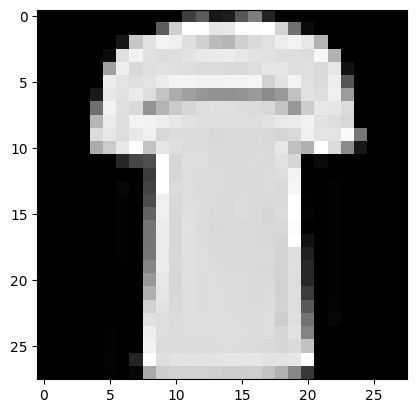

In [18]:
data_number = 24
prueba = X[data_number].detach().numpy().reshape(28, 28)
plt.imshow(prueba, cmap = "gray")

In [83]:
y[data_number]

tensor(0.)

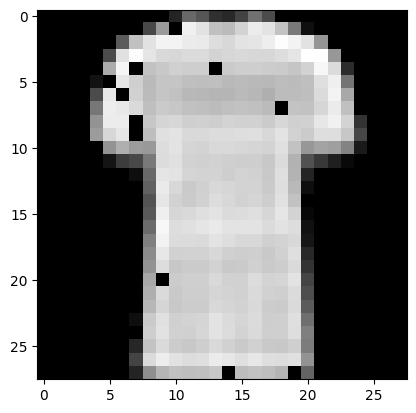

In [19]:
prueba_out = out[data_number].detach().numpy().reshape(28, 28)
plt.imshow(prueba_out, cmap = "gray")

Training a MLP for classification with embeddings of the previous GNN model

In [20]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers, output_size, lr, criterion, use_embeddings = True):
    super().__init__()
    
    self.criterion = criterion
    activation = nn.ReLU()
    self.MLP_layers = nn.ModuleList()
    layer = nn.Linear(input_size, hidden_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(activation)
    self.use_embeddings = use_embeddings

    for _ in range(num_hidden_layers - 1):

      layer = nn.Linear(hidden_size, hidden_size)
      nn.init.xavier_uniform(layer.weight)
      layer.bias.data.fill_(0.01)
      self.MLP_layers.append(layer)
      self.MLP_layers.append(activation)

    layer = nn.Linear(hidden_size, output_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(nn.Sigmoid())

    self.optimizer = Adam(self.parameters(), lr)

  def forward(self, x):
    for layer in self.MLP_layers:
      x = layer(x)

    return x
  
  def train_model(self, train_loader):

    self.train()

    epoch_losses = []
    epoch_accuracies = []

    for X, y in tqdm(train_loader):

      self.optimizer.zero_grad()
      if self.use_embeddings:
        with torch.no_grad():
          Z = model.encode(X)
        out = self.forward(Z)
      else:
        out = self.forward(X)
      
      loss = self.criterion(out, y.long())
      preds = torch.argmax(out, dim = 1)
      accuracy = torch.mean((preds == y.long()).float())
      epoch_losses.append(loss)
      epoch_accuracies.append(accuracy)
      loss.backward()
      self.optimizer.step()

    avg_loss = torch.mean(torch.Tensor(epoch_losses))
    avg_accuracy = torch.mean(torch.Tensor(epoch_accuracies))

    return avg_loss.item(), avg_accuracy.item()
  
  def test_model(self, data_loader):

    self.eval()

    test_losses = []
    test_accuracies = []

    for X, y in tqdm(data_loader):
        if self.use_embeddings:
          with torch.no_grad():
            Z = model.encode(X)
          out = self.forward(Z)
        else:
          out = self.forward(X)
        
        loss = self.criterion(out, y.long())
        preds = torch.argmax(out, dim = 1)
        accuracy = torch.mean((preds == y.long()).float())
        test_losses.append(loss)
        test_accuracies.append(accuracy)
    avg_loss = torch.mean(torch.Tensor(test_losses))
    avg_accuracy = torch.mean(torch.Tensor(test_accuracies))

    return avg_loss.item(), avg_accuracy.item()


In [21]:
lr_classif = 0.001
loss = nn.CrossEntropyLoss()
classif = MLP(latent_size, 64, 1, 10, lr_classif, loss, use_embeddings = True)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13388\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_13388\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [97]:
classif.parameters

<bound method Module.parameters of MLP(
  (criterion): CrossEntropyLoss()
  (MLP_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): Sigmoid()
  )
)>

In [22]:
epochs_classif = 200

In [24]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 22/22 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5419, avg_accuracy_train: 0.8604
avg_loss_val: 1.5533, avg_accuracy_val: 0.8571
epoch: 2/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5421, avg_accuracy_train: 0.8603
avg_loss_val: 1.5534, avg_accuracy_val: 0.8574
epoch: 3/200


100%|██████████| 22/22 [00:00<00:00, 224.28it/s]


avg_loss_train: 1.5418, avg_accuracy_train: 0.8602
avg_loss_val: 1.5527, avg_accuracy_val: 0.8563
epoch: 4/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5418, avg_accuracy_train: 0.8597
avg_loss_val: 1.5545, avg_accuracy_val: 0.8562
epoch: 5/200


100%|██████████| 22/22 [00:00<00:00, 198.02it/s]


avg_loss_train: 1.5420, avg_accuracy_train: 0.8604
avg_loss_val: 1.5529, avg_accuracy_val: 0.8577
epoch: 6/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5420, avg_accuracy_train: 0.8602
avg_loss_val: 1.5535, avg_accuracy_val: 0.8567
epoch: 7/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5421, avg_accuracy_train: 0.8592
avg_loss_val: 1.5529, avg_accuracy_val: 0.8589
epoch: 8/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5415, avg_accuracy_train: 0.8604
avg_loss_val: 1.5536, avg_accuracy_val: 0.8593
epoch: 9/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5414, avg_accuracy_train: 0.8607
avg_loss_val: 1.5533, avg_accuracy_val: 0.8569
epoch: 10/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5415, avg_accuracy_train: 0.8601
avg_loss_val: 1.5531, avg_accuracy_val: 0.8553
epoch: 11/200


100%|██████████| 22/22 [00:00<00:00, 220.85it/s]


avg_loss_train: 1.5415, avg_accuracy_train: 0.8603
avg_loss_val: 1.5531, avg_accuracy_val: 0.8575
epoch: 12/200


100%|██████████| 22/22 [00:00<00:00, 224.44it/s]


avg_loss_train: 1.5415, avg_accuracy_train: 0.8608
avg_loss_val: 1.5529, avg_accuracy_val: 0.8589
epoch: 13/200


100%|██████████| 22/22 [00:00<00:00, 199.82it/s]


avg_loss_train: 1.5414, avg_accuracy_train: 0.8617
avg_loss_val: 1.5532, avg_accuracy_val: 0.8570
epoch: 14/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5412, avg_accuracy_train: 0.8608
avg_loss_val: 1.5542, avg_accuracy_val: 0.8550
epoch: 15/200


100%|██████████| 22/22 [00:00<00:00, 228.96it/s]


avg_loss_train: 1.5409, avg_accuracy_train: 0.8613
avg_loss_val: 1.5525, avg_accuracy_val: 0.8551
epoch: 16/200


100%|██████████| 22/22 [00:00<00:00, 231.37it/s]


avg_loss_train: 1.5410, avg_accuracy_train: 0.8612
avg_loss_val: 1.5530, avg_accuracy_val: 0.8581
epoch: 17/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5408, avg_accuracy_train: 0.8608
avg_loss_val: 1.5532, avg_accuracy_val: 0.8587
epoch: 18/200


100%|██████████| 22/22 [00:00<00:00, 211.34it/s]


avg_loss_train: 1.5412, avg_accuracy_train: 0.8603
avg_loss_val: 1.5555, avg_accuracy_val: 0.8590
epoch: 19/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5414, avg_accuracy_train: 0.8601
avg_loss_val: 1.5535, avg_accuracy_val: 0.8583
epoch: 20/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5405, avg_accuracy_train: 0.8615
avg_loss_val: 1.5535, avg_accuracy_val: 0.8554
epoch: 21/200


100%|██████████| 22/22 [00:00<00:00, 178.70it/s]


avg_loss_train: 1.5407, avg_accuracy_train: 0.8616
avg_loss_val: 1.5529, avg_accuracy_val: 0.8594
epoch: 22/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5408, avg_accuracy_train: 0.8609
avg_loss_val: 1.5536, avg_accuracy_val: 0.8571
epoch: 23/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5407, avg_accuracy_train: 0.8614
avg_loss_val: 1.5533, avg_accuracy_val: 0.8594
epoch: 24/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5406, avg_accuracy_train: 0.8618
avg_loss_val: 1.5526, avg_accuracy_val: 0.8570
epoch: 25/200


100%|██████████| 22/22 [00:00<00:00, 223.45it/s]


avg_loss_train: 1.5402, avg_accuracy_train: 0.8616
avg_loss_val: 1.5530, avg_accuracy_val: 0.8596
epoch: 26/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5406, avg_accuracy_train: 0.8617
avg_loss_val: 1.5540, avg_accuracy_val: 0.8588
epoch: 27/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5405, avg_accuracy_train: 0.8616
avg_loss_val: 1.5525, avg_accuracy_val: 0.8583
epoch: 28/200


100%|██████████| 22/22 [00:00<00:00, 203.52it/s]


avg_loss_train: 1.5403, avg_accuracy_train: 0.8613
avg_loss_val: 1.5520, avg_accuracy_val: 0.8589
epoch: 29/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5403, avg_accuracy_train: 0.8612
avg_loss_val: 1.5530, avg_accuracy_val: 0.8602
epoch: 30/200


100%|██████████| 22/22 [00:00<00:00, 201.65it/s]


avg_loss_train: 1.5402, avg_accuracy_train: 0.8612
avg_loss_val: 1.5531, avg_accuracy_val: 0.8591
epoch: 31/200


100%|██████████| 22/22 [00:00<00:00, 224.29it/s]


avg_loss_train: 1.5402, avg_accuracy_train: 0.8615
avg_loss_val: 1.5521, avg_accuracy_val: 0.8587
epoch: 32/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5401, avg_accuracy_train: 0.8614
avg_loss_val: 1.5524, avg_accuracy_val: 0.8586
epoch: 33/200


100%|██████████| 22/22 [00:00<00:00, 224.28it/s]


avg_loss_train: 1.5399, avg_accuracy_train: 0.8620
avg_loss_val: 1.5527, avg_accuracy_val: 0.8573
epoch: 34/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5397, avg_accuracy_train: 0.8617
avg_loss_val: 1.5528, avg_accuracy_val: 0.8593
epoch: 35/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5398, avg_accuracy_train: 0.8611
avg_loss_val: 1.5530, avg_accuracy_val: 0.8576
epoch: 36/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5396, avg_accuracy_train: 0.8616
avg_loss_val: 1.5533, avg_accuracy_val: 0.8594
epoch: 37/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5399, avg_accuracy_train: 0.8617
avg_loss_val: 1.5525, avg_accuracy_val: 0.8604
epoch: 38/200


100%|██████████| 22/22 [00:00<00:00, 203.52it/s]


avg_loss_train: 1.5395, avg_accuracy_train: 0.8622
avg_loss_val: 1.5529, avg_accuracy_val: 0.8601
epoch: 39/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5395, avg_accuracy_train: 0.8613
avg_loss_val: 1.5518, avg_accuracy_val: 0.8619
epoch: 40/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5395, avg_accuracy_train: 0.8616
avg_loss_val: 1.5537, avg_accuracy_val: 0.8590
epoch: 41/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5398, avg_accuracy_train: 0.8605
avg_loss_val: 1.5539, avg_accuracy_val: 0.8595
epoch: 42/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5397, avg_accuracy_train: 0.8617
avg_loss_val: 1.5527, avg_accuracy_val: 0.8601
epoch: 43/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5395, avg_accuracy_train: 0.8621
avg_loss_val: 1.5521, avg_accuracy_val: 0.8610
epoch: 44/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5394, avg_accuracy_train: 0.8622
avg_loss_val: 1.5523, avg_accuracy_val: 0.8562
epoch: 45/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5393, avg_accuracy_train: 0.8620
avg_loss_val: 1.5525, avg_accuracy_val: 0.8608
epoch: 46/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5392, avg_accuracy_train: 0.8616
avg_loss_val: 1.5528, avg_accuracy_val: 0.8591
epoch: 47/200


100%|██████████| 22/22 [00:00<00:00, 205.42it/s]


avg_loss_train: 1.5392, avg_accuracy_train: 0.8614
avg_loss_val: 1.5525, avg_accuracy_val: 0.8575
epoch: 48/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5391, avg_accuracy_train: 0.8618
avg_loss_val: 1.5528, avg_accuracy_val: 0.8590
epoch: 49/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5391, avg_accuracy_train: 0.8631
avg_loss_val: 1.5527, avg_accuracy_val: 0.8609
epoch: 50/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5389, avg_accuracy_train: 0.8632
avg_loss_val: 1.5526, avg_accuracy_val: 0.8602
epoch: 51/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5390, avg_accuracy_train: 0.8624
avg_loss_val: 1.5526, avg_accuracy_val: 0.8617
epoch: 52/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5391, avg_accuracy_train: 0.8623
avg_loss_val: 1.5527, avg_accuracy_val: 0.8597
epoch: 53/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5388, avg_accuracy_train: 0.8622
avg_loss_val: 1.5528, avg_accuracy_val: 0.8608
epoch: 54/200


100%|██████████| 22/22 [00:00<00:00, 211.34it/s]


avg_loss_train: 1.5388, avg_accuracy_train: 0.8623
avg_loss_val: 1.5526, avg_accuracy_val: 0.8613
epoch: 55/200


100%|██████████| 22/22 [00:00<00:00, 228.10it/s]


avg_loss_train: 1.5388, avg_accuracy_train: 0.8630
avg_loss_val: 1.5522, avg_accuracy_val: 0.8603
epoch: 56/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5387, avg_accuracy_train: 0.8622
avg_loss_val: 1.5533, avg_accuracy_val: 0.8604
epoch: 57/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5386, avg_accuracy_train: 0.8626
avg_loss_val: 1.5519, avg_accuracy_val: 0.8587
epoch: 58/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5389, avg_accuracy_train: 0.8627
avg_loss_val: 1.5524, avg_accuracy_val: 0.8598
epoch: 59/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5385, avg_accuracy_train: 0.8627
avg_loss_val: 1.5522, avg_accuracy_val: 0.8588
epoch: 60/200


100%|██████████| 22/22 [00:00<00:00, 224.28it/s]


avg_loss_train: 1.5380, avg_accuracy_train: 0.8630
avg_loss_val: 1.5518, avg_accuracy_val: 0.8618
epoch: 61/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5385, avg_accuracy_train: 0.8632
avg_loss_val: 1.5525, avg_accuracy_val: 0.8597
epoch: 62/200


100%|██████████| 22/22 [00:00<00:00, 224.29it/s]


avg_loss_train: 1.5384, avg_accuracy_train: 0.8630
avg_loss_val: 1.5520, avg_accuracy_val: 0.8604
epoch: 63/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5383, avg_accuracy_train: 0.8631
avg_loss_val: 1.5527, avg_accuracy_val: 0.8619
epoch: 64/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5381, avg_accuracy_train: 0.8632
avg_loss_val: 1.5526, avg_accuracy_val: 0.8616
epoch: 65/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5382, avg_accuracy_train: 0.8631
avg_loss_val: 1.5520, avg_accuracy_val: 0.8608
epoch: 66/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5382, avg_accuracy_train: 0.8631
avg_loss_val: 1.5521, avg_accuracy_val: 0.8588
epoch: 67/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5380, avg_accuracy_train: 0.8630
avg_loss_val: 1.5518, avg_accuracy_val: 0.8628
epoch: 68/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5383, avg_accuracy_train: 0.8626
avg_loss_val: 1.5523, avg_accuracy_val: 0.8603
epoch: 69/200


100%|██████████| 22/22 [00:00<00:00, 213.39it/s]


avg_loss_train: 1.5380, avg_accuracy_train: 0.8631
avg_loss_val: 1.5521, avg_accuracy_val: 0.8601
epoch: 70/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5380, avg_accuracy_train: 0.8637
avg_loss_val: 1.5522, avg_accuracy_val: 0.8614
epoch: 71/200


100%|██████████| 22/22 [00:00<00:00, 213.39it/s]


avg_loss_train: 1.5378, avg_accuracy_train: 0.8633
avg_loss_val: 1.5530, avg_accuracy_val: 0.8597
epoch: 72/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5378, avg_accuracy_train: 0.8625
avg_loss_val: 1.5532, avg_accuracy_val: 0.8612
epoch: 73/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5381, avg_accuracy_train: 0.8633
avg_loss_val: 1.5519, avg_accuracy_val: 0.8603
epoch: 74/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5376, avg_accuracy_train: 0.8630
avg_loss_val: 1.5517, avg_accuracy_val: 0.8610
epoch: 75/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5379, avg_accuracy_train: 0.8626
avg_loss_val: 1.5518, avg_accuracy_val: 0.8629
epoch: 76/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5379, avg_accuracy_train: 0.8626
avg_loss_val: 1.5521, avg_accuracy_val: 0.8605
epoch: 77/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5374, avg_accuracy_train: 0.8634
avg_loss_val: 1.5529, avg_accuracy_val: 0.8613
epoch: 78/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5375, avg_accuracy_train: 0.8632
avg_loss_val: 1.5519, avg_accuracy_val: 0.8579
epoch: 79/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5376, avg_accuracy_train: 0.8641
avg_loss_val: 1.5523, avg_accuracy_val: 0.8611
epoch: 80/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5375, avg_accuracy_train: 0.8638
avg_loss_val: 1.5533, avg_accuracy_val: 0.8594
epoch: 81/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5374, avg_accuracy_train: 0.8636
avg_loss_val: 1.5524, avg_accuracy_val: 0.8613
epoch: 82/200


100%|██████████| 22/22 [00:00<00:00, 216.23it/s]


avg_loss_train: 1.5376, avg_accuracy_train: 0.8638
avg_loss_val: 1.5524, avg_accuracy_val: 0.8627
epoch: 83/200


100%|██████████| 22/22 [00:00<00:00, 224.28it/s]


avg_loss_train: 1.5376, avg_accuracy_train: 0.8636
avg_loss_val: 1.5522, avg_accuracy_val: 0.8608
epoch: 84/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5374, avg_accuracy_train: 0.8637
avg_loss_val: 1.5519, avg_accuracy_val: 0.8613
epoch: 85/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5373, avg_accuracy_train: 0.8643
avg_loss_val: 1.5524, avg_accuracy_val: 0.8618
epoch: 86/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5373, avg_accuracy_train: 0.8642
avg_loss_val: 1.5524, avg_accuracy_val: 0.8618
epoch: 87/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5373, avg_accuracy_train: 0.8637
avg_loss_val: 1.5519, avg_accuracy_val: 0.8610
epoch: 88/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5373, avg_accuracy_train: 0.8637
avg_loss_val: 1.5531, avg_accuracy_val: 0.8601
epoch: 89/200


100%|██████████| 22/22 [00:00<00:00, 201.65it/s]


avg_loss_train: 1.5371, avg_accuracy_train: 0.8634
avg_loss_val: 1.5526, avg_accuracy_val: 0.8593
epoch: 90/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5373, avg_accuracy_train: 0.8639
avg_loss_val: 1.5512, avg_accuracy_val: 0.8622
epoch: 91/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5371, avg_accuracy_train: 0.8637
avg_loss_val: 1.5522, avg_accuracy_val: 0.8601
epoch: 92/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5370, avg_accuracy_train: 0.8643
avg_loss_val: 1.5517, avg_accuracy_val: 0.8602
epoch: 93/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5370, avg_accuracy_train: 0.8636
avg_loss_val: 1.5517, avg_accuracy_val: 0.8610
epoch: 94/200


100%|██████████| 22/22 [00:00<00:00, 214.42it/s]


avg_loss_train: 1.5368, avg_accuracy_train: 0.8636
avg_loss_val: 1.5521, avg_accuracy_val: 0.8610
epoch: 95/200


100%|██████████| 22/22 [00:00<00:00, 203.52it/s]


avg_loss_train: 1.5368, avg_accuracy_train: 0.8637
avg_loss_val: 1.5525, avg_accuracy_val: 0.8628
epoch: 96/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5366, avg_accuracy_train: 0.8641
avg_loss_val: 1.5516, avg_accuracy_val: 0.8616
epoch: 97/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5370, avg_accuracy_train: 0.8637
avg_loss_val: 1.5521, avg_accuracy_val: 0.8591
epoch: 98/200


100%|██████████| 22/22 [00:00<00:00, 199.82it/s]


avg_loss_train: 1.5367, avg_accuracy_train: 0.8640
avg_loss_val: 1.5528, avg_accuracy_val: 0.8615
epoch: 99/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5368, avg_accuracy_train: 0.8642
avg_loss_val: 1.5523, avg_accuracy_val: 0.8610
epoch: 100/200


100%|██████████| 22/22 [00:00<00:00, 228.96it/s]


avg_loss_train: 1.5364, avg_accuracy_train: 0.8640
avg_loss_val: 1.5526, avg_accuracy_val: 0.8594
epoch: 101/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5367, avg_accuracy_train: 0.8632
avg_loss_val: 1.5515, avg_accuracy_val: 0.8611
epoch: 102/200


100%|██████████| 22/22 [00:00<00:00, 217.47it/s]


avg_loss_train: 1.5363, avg_accuracy_train: 0.8645
avg_loss_val: 1.5515, avg_accuracy_val: 0.8599
epoch: 103/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5365, avg_accuracy_train: 0.8641
avg_loss_val: 1.5518, avg_accuracy_val: 0.8612
epoch: 104/200


100%|██████████| 22/22 [00:00<00:00, 224.28it/s]


avg_loss_train: 1.5363, avg_accuracy_train: 0.8641
avg_loss_val: 1.5524, avg_accuracy_val: 0.8616
epoch: 105/200


100%|██████████| 22/22 [00:00<00:00, 219.80it/s]


avg_loss_train: 1.5367, avg_accuracy_train: 0.8640
avg_loss_val: 1.5522, avg_accuracy_val: 0.8628
epoch: 106/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5363, avg_accuracy_train: 0.8649
avg_loss_val: 1.5511, avg_accuracy_val: 0.8612
epoch: 107/200


100%|██████████| 22/22 [00:00<00:00, 219.80it/s]


avg_loss_train: 1.5362, avg_accuracy_train: 0.8639
avg_loss_val: 1.5518, avg_accuracy_val: 0.8632
epoch: 108/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5364, avg_accuracy_train: 0.8650
avg_loss_val: 1.5516, avg_accuracy_val: 0.8628
epoch: 109/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5366, avg_accuracy_train: 0.8638
avg_loss_val: 1.5521, avg_accuracy_val: 0.8628
epoch: 110/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5363, avg_accuracy_train: 0.8639
avg_loss_val: 1.5518, avg_accuracy_val: 0.8611
epoch: 111/200


100%|██████████| 22/22 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5362, avg_accuracy_train: 0.8644
avg_loss_val: 1.5512, avg_accuracy_val: 0.8607
epoch: 112/200


100%|██████████| 22/22 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8645
avg_loss_val: 1.5523, avg_accuracy_val: 0.8619
epoch: 113/200


100%|██████████| 22/22 [00:00<00:00, 224.29it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8652
avg_loss_val: 1.5518, avg_accuracy_val: 0.8622
epoch: 114/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5360, avg_accuracy_train: 0.8641
avg_loss_val: 1.5520, avg_accuracy_val: 0.8607
epoch: 115/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8644
avg_loss_val: 1.5523, avg_accuracy_val: 0.8624
epoch: 116/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8647
avg_loss_val: 1.5521, avg_accuracy_val: 0.8627
epoch: 117/200


100%|██████████| 22/22 [00:00<00:00, 228.96it/s]


avg_loss_train: 1.5359, avg_accuracy_train: 0.8648
avg_loss_val: 1.5518, avg_accuracy_val: 0.8611
epoch: 118/200


100%|██████████| 22/22 [00:00<00:00, 188.69it/s]


avg_loss_train: 1.5358, avg_accuracy_train: 0.8647
avg_loss_val: 1.5521, avg_accuracy_val: 0.8607
epoch: 119/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5358, avg_accuracy_train: 0.8647
avg_loss_val: 1.5514, avg_accuracy_val: 0.8621
epoch: 120/200


100%|██████████| 22/22 [00:00<00:00, 224.29it/s]


avg_loss_train: 1.5359, avg_accuracy_train: 0.8646
avg_loss_val: 1.5518, avg_accuracy_val: 0.8611
epoch: 121/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5357, avg_accuracy_train: 0.8645
avg_loss_val: 1.5526, avg_accuracy_val: 0.8618
epoch: 122/200


100%|██████████| 22/22 [00:00<00:00, 224.29it/s]


avg_loss_train: 1.5357, avg_accuracy_train: 0.8648
avg_loss_val: 1.5517, avg_accuracy_val: 0.8640
epoch: 123/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8652
avg_loss_val: 1.5520, avg_accuracy_val: 0.8609
epoch: 124/200


100%|██████████| 22/22 [00:00<00:00, 208.77it/s]


avg_loss_train: 1.5357, avg_accuracy_train: 0.8641
avg_loss_val: 1.5516, avg_accuracy_val: 0.8610
epoch: 125/200


100%|██████████| 22/22 [00:00<00:00, 181.26it/s]


avg_loss_train: 1.5355, avg_accuracy_train: 0.8649
avg_loss_val: 1.5520, avg_accuracy_val: 0.8617
epoch: 126/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8638
avg_loss_val: 1.5523, avg_accuracy_val: 0.8606
epoch: 127/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8643
avg_loss_val: 1.5529, avg_accuracy_val: 0.8604
epoch: 128/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5359, avg_accuracy_train: 0.8641
avg_loss_val: 1.5526, avg_accuracy_val: 0.8612
epoch: 129/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5354, avg_accuracy_train: 0.8644
avg_loss_val: 1.5532, avg_accuracy_val: 0.8614
epoch: 130/200


100%|██████████| 22/22 [00:00<00:00, 224.28it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8642
avg_loss_val: 1.5519, avg_accuracy_val: 0.8614
epoch: 131/200


100%|██████████| 22/22 [00:00<00:00, 220.06it/s]


avg_loss_train: 1.5353, avg_accuracy_train: 0.8648
avg_loss_val: 1.5519, avg_accuracy_val: 0.8618
epoch: 132/200


100%|██████████| 22/22 [00:00<00:00, 192.80it/s]


avg_loss_train: 1.5352, avg_accuracy_train: 0.8650
avg_loss_val: 1.5512, avg_accuracy_val: 0.8613
epoch: 133/200


100%|██████████| 22/22 [00:00<00:00, 217.63it/s]


avg_loss_train: 1.5352, avg_accuracy_train: 0.8638
avg_loss_val: 1.5521, avg_accuracy_val: 0.8640
epoch: 134/200


100%|██████████| 22/22 [00:00<00:00, 224.28it/s]


avg_loss_train: 1.5352, avg_accuracy_train: 0.8648
avg_loss_val: 1.5524, avg_accuracy_val: 0.8625
epoch: 135/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5354, avg_accuracy_train: 0.8657
avg_loss_val: 1.5520, avg_accuracy_val: 0.8608
epoch: 136/200


100%|██████████| 22/22 [00:00<00:00, 203.52it/s]


avg_loss_train: 1.5351, avg_accuracy_train: 0.8649
avg_loss_val: 1.5518, avg_accuracy_val: 0.8629
epoch: 137/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5354, avg_accuracy_train: 0.8646
avg_loss_val: 1.5518, avg_accuracy_val: 0.8633
epoch: 138/200


100%|██████████| 22/22 [00:00<00:00, 152.22it/s]


avg_loss_train: 1.5355, avg_accuracy_train: 0.8647
avg_loss_val: 1.5518, avg_accuracy_val: 0.8612
epoch: 139/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5354, avg_accuracy_train: 0.8646
avg_loss_val: 1.5516, avg_accuracy_val: 0.8616
epoch: 140/200


100%|██████████| 22/22 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5352, avg_accuracy_train: 0.8640
avg_loss_val: 1.5519, avg_accuracy_val: 0.8597
epoch: 141/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5350, avg_accuracy_train: 0.8650
avg_loss_val: 1.5528, avg_accuracy_val: 0.8632
epoch: 142/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5351, avg_accuracy_train: 0.8647
avg_loss_val: 1.5519, avg_accuracy_val: 0.8638
epoch: 143/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5351, avg_accuracy_train: 0.8652
avg_loss_val: 1.5522, avg_accuracy_val: 0.8622
epoch: 144/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5348, avg_accuracy_train: 0.8653
avg_loss_val: 1.5520, avg_accuracy_val: 0.8613
epoch: 145/200


100%|██████████| 22/22 [00:00<00:00, 211.33it/s]


avg_loss_train: 1.5347, avg_accuracy_train: 0.8650
avg_loss_val: 1.5516, avg_accuracy_val: 0.8626
epoch: 146/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5351, avg_accuracy_train: 0.8655
avg_loss_val: 1.5524, avg_accuracy_val: 0.8616
epoch: 147/200


100%|██████████| 22/22 [00:00<00:00, 201.65it/s]


avg_loss_train: 1.5350, avg_accuracy_train: 0.8649
avg_loss_val: 1.5518, avg_accuracy_val: 0.8629
epoch: 148/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5349, avg_accuracy_train: 0.8647
avg_loss_val: 1.5517, avg_accuracy_val: 0.8596
epoch: 149/200


100%|██████████| 22/22 [00:00<00:00, 191.13it/s]


avg_loss_train: 1.5350, avg_accuracy_train: 0.8643
avg_loss_val: 1.5522, avg_accuracy_val: 0.8654
epoch: 150/200


100%|██████████| 22/22 [00:00<00:00, 226.60it/s]


avg_loss_train: 1.5348, avg_accuracy_train: 0.8651
avg_loss_val: 1.5519, avg_accuracy_val: 0.8626
epoch: 151/200


100%|██████████| 22/22 [00:00<00:00, 205.42it/s]


avg_loss_train: 1.5346, avg_accuracy_train: 0.8645
avg_loss_val: 1.5516, avg_accuracy_val: 0.8632
epoch: 152/200


100%|██████████| 22/22 [00:00<00:00, 204.45it/s]


avg_loss_train: 1.5347, avg_accuracy_train: 0.8647
avg_loss_val: 1.5511, avg_accuracy_val: 0.8610
epoch: 153/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5346, avg_accuracy_train: 0.8653
avg_loss_val: 1.5515, avg_accuracy_val: 0.8602
epoch: 154/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5349, avg_accuracy_train: 0.8651
avg_loss_val: 1.5525, avg_accuracy_val: 0.8631
epoch: 155/200


100%|██████████| 22/22 [00:00<00:00, 211.34it/s]


avg_loss_train: 1.5344, avg_accuracy_train: 0.8644
avg_loss_val: 1.5518, avg_accuracy_val: 0.8612
epoch: 156/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5348, avg_accuracy_train: 0.8649
avg_loss_val: 1.5520, avg_accuracy_val: 0.8598
epoch: 157/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5348, avg_accuracy_train: 0.8644
avg_loss_val: 1.5518, avg_accuracy_val: 0.8608
epoch: 158/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5345, avg_accuracy_train: 0.8647
avg_loss_val: 1.5519, avg_accuracy_val: 0.8644
epoch: 159/200


100%|██████████| 22/22 [00:00<00:00, 170.81it/s]


avg_loss_train: 1.5345, avg_accuracy_train: 0.8649
avg_loss_val: 1.5524, avg_accuracy_val: 0.8636
epoch: 160/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5343, avg_accuracy_train: 0.8648
avg_loss_val: 1.5519, avg_accuracy_val: 0.8605
epoch: 161/200


100%|██████████| 22/22 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5342, avg_accuracy_train: 0.8650
avg_loss_val: 1.5519, avg_accuracy_val: 0.8641
epoch: 162/200


100%|██████████| 22/22 [00:00<00:00, 224.28it/s]


avg_loss_train: 1.5342, avg_accuracy_train: 0.8651
avg_loss_val: 1.5515, avg_accuracy_val: 0.8631
epoch: 163/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5342, avg_accuracy_train: 0.8655
avg_loss_val: 1.5520, avg_accuracy_val: 0.8621
epoch: 164/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5342, avg_accuracy_train: 0.8652
avg_loss_val: 1.5524, avg_accuracy_val: 0.8614
epoch: 165/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5344, avg_accuracy_train: 0.8645
avg_loss_val: 1.5524, avg_accuracy_val: 0.8617
epoch: 166/200


100%|██████████| 22/22 [00:00<00:00, 117.54it/s]


avg_loss_train: 1.5340, avg_accuracy_train: 0.8649
avg_loss_val: 1.5516, avg_accuracy_val: 0.8617
epoch: 167/200


100%|██████████| 22/22 [00:00<00:00, 217.62it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8651
avg_loss_val: 1.5519, avg_accuracy_val: 0.8628
epoch: 168/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5340, avg_accuracy_train: 0.8651
avg_loss_val: 1.5517, avg_accuracy_val: 0.8637
epoch: 169/200


100%|██████████| 22/22 [00:00<00:00, 205.42it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8648
avg_loss_val: 1.5517, avg_accuracy_val: 0.8626
epoch: 170/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8648
avg_loss_val: 1.5523, avg_accuracy_val: 0.8653
epoch: 171/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8644
avg_loss_val: 1.5526, avg_accuracy_val: 0.8632
epoch: 172/200


100%|██████████| 22/22 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5342, avg_accuracy_train: 0.8651
avg_loss_val: 1.5518, avg_accuracy_val: 0.8626
epoch: 173/200


100%|██████████| 22/22 [00:00<00:00, 218.69it/s]


avg_loss_train: 1.5342, avg_accuracy_train: 0.8651
avg_loss_val: 1.5518, avg_accuracy_val: 0.8588
epoch: 174/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5343, avg_accuracy_train: 0.8650
avg_loss_val: 1.5518, avg_accuracy_val: 0.8635
epoch: 175/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8648
avg_loss_val: 1.5520, avg_accuracy_val: 0.8617
epoch: 176/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5340, avg_accuracy_train: 0.8653
avg_loss_val: 1.5525, avg_accuracy_val: 0.8637
epoch: 177/200


100%|██████████| 22/22 [00:00<00:00, 205.42it/s]


avg_loss_train: 1.5340, avg_accuracy_train: 0.8649
avg_loss_val: 1.5525, avg_accuracy_val: 0.8606
epoch: 178/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5339, avg_accuracy_train: 0.8660
avg_loss_val: 1.5526, avg_accuracy_val: 0.8631
epoch: 179/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5338, avg_accuracy_train: 0.8647
avg_loss_val: 1.5518, avg_accuracy_val: 0.8635
epoch: 180/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5338, avg_accuracy_train: 0.8645
avg_loss_val: 1.5514, avg_accuracy_val: 0.8634
epoch: 181/200


100%|██████████| 22/22 [00:00<00:00, 219.80it/s]


avg_loss_train: 1.5338, avg_accuracy_train: 0.8654
avg_loss_val: 1.5531, avg_accuracy_val: 0.8602
epoch: 182/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5338, avg_accuracy_train: 0.8652
avg_loss_val: 1.5516, avg_accuracy_val: 0.8643
epoch: 183/200


100%|██████████| 22/22 [00:00<00:00, 100.83it/s]


avg_loss_train: 1.5337, avg_accuracy_train: 0.8654
avg_loss_val: 1.5516, avg_accuracy_val: 0.8623
epoch: 184/200


100%|██████████| 22/22 [00:00<00:00, 205.42it/s]


avg_loss_train: 1.5336, avg_accuracy_train: 0.8651
avg_loss_val: 1.5523, avg_accuracy_val: 0.8618
epoch: 185/200


100%|██████████| 22/22 [00:00<00:00, 198.02it/s]


avg_loss_train: 1.5336, avg_accuracy_train: 0.8653
avg_loss_val: 1.5518, avg_accuracy_val: 0.8613
epoch: 186/200


100%|██████████| 22/22 [00:00<00:00, 191.13it/s]


avg_loss_train: 1.5340, avg_accuracy_train: 0.8654
avg_loss_val: 1.5519, avg_accuracy_val: 0.8626
epoch: 187/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5336, avg_accuracy_train: 0.8653
avg_loss_val: 1.5513, avg_accuracy_val: 0.8626
epoch: 188/200


100%|██████████| 22/22 [00:00<00:00, 221.17it/s]


avg_loss_train: 1.5335, avg_accuracy_train: 0.8654
avg_loss_val: 1.5518, avg_accuracy_val: 0.8623
epoch: 189/200


100%|██████████| 22/22 [00:00<00:00, 222.02it/s]


avg_loss_train: 1.5335, avg_accuracy_train: 0.8653
avg_loss_val: 1.5517, avg_accuracy_val: 0.8620
epoch: 190/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5334, avg_accuracy_train: 0.8655
avg_loss_val: 1.5530, avg_accuracy_val: 0.8626
epoch: 191/200


100%|██████████| 22/22 [00:00<00:00, 198.02it/s]


avg_loss_train: 1.5335, avg_accuracy_train: 0.8657
avg_loss_val: 1.5517, avg_accuracy_val: 0.8629
epoch: 192/200


100%|██████████| 22/22 [00:00<00:00, 209.33it/s]


avg_loss_train: 1.5333, avg_accuracy_train: 0.8651
avg_loss_val: 1.5512, avg_accuracy_val: 0.8619
epoch: 193/200


100%|██████████| 22/22 [00:00<00:00, 210.32it/s]


avg_loss_train: 1.5333, avg_accuracy_train: 0.8654
avg_loss_val: 1.5518, avg_accuracy_val: 0.8596
epoch: 194/200


100%|██████████| 22/22 [00:00<00:00, 215.49it/s]


avg_loss_train: 1.5333, avg_accuracy_train: 0.8662
avg_loss_val: 1.5522, avg_accuracy_val: 0.8625
epoch: 195/200


100%|██████████| 22/22 [00:00<00:00, 213.40it/s]


avg_loss_train: 1.5333, avg_accuracy_train: 0.8657
avg_loss_val: 1.5514, avg_accuracy_val: 0.8632
epoch: 196/200


100%|██████████| 22/22 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5335, avg_accuracy_train: 0.8651
avg_loss_val: 1.5517, avg_accuracy_val: 0.8618
epoch: 197/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5330, avg_accuracy_train: 0.8653
avg_loss_val: 1.5519, avg_accuracy_val: 0.8616
epoch: 198/200


100%|██████████| 22/22 [00:00<00:00, 211.35it/s]


avg_loss_train: 1.5330, avg_accuracy_train: 0.8656
avg_loss_val: 1.5513, avg_accuracy_val: 0.8637
epoch: 199/200


100%|██████████| 22/22 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.5335, avg_accuracy_train: 0.8659
avg_loss_val: 1.5516, avg_accuracy_val: 0.8611
epoch: 200/200


100%|██████████| 22/22 [00:00<00:00, 106.18it/s]

avg_loss_train: 1.5330, avg_accuracy_train: 0.8663
avg_loss_val: 1.5514, avg_accuracy_val: 0.8642


In [27]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 55/55 [00:00<00:00, 305.80it/s]

avg_loss_test: 1.5527, avg_accuracy_test: 0.8578


Comparing with MLP trained on input images

In [28]:
classif_inputs = MLP(input_size, 16, 3, 10, lr_classif, loss, use_embeddings = False)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_13388\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_13388\3759001460.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_13388\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [106]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif_inputs.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif_inputs.test_model(val_loader)
    
    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.9502, avg_accuracy_train: 0.3440
avg_loss_val: 1.7657, avg_accuracy_val: 0.3647
epoch: 2/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.7177, avg_accuracy_train: 0.4103
avg_loss_val: 1.6834, avg_accuracy_val: 0.4367
epoch: 3/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.6723, avg_accuracy_train: 0.4525
avg_loss_val: 1.6628, avg_accuracy_val: 0.4819
epoch: 4/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.6579, avg_accuracy_train: 0.4794
avg_loss_val: 1.6538, avg_accuracy_val: 0.4858
epoch: 5/200


100%|██████████| 11/11 [00:00<00:00, 199.82it/s]


avg_loss_train: 1.6514, avg_accuracy_train: 0.4908
avg_loss_val: 1.6495, avg_accuracy_val: 0.4991
epoch: 6/200


100%|██████████| 11/11 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.6459, avg_accuracy_train: 0.4996
avg_loss_val: 1.6460, avg_accuracy_val: 0.5232
epoch: 7/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.6423, avg_accuracy_train: 0.5277
avg_loss_val: 1.6433, avg_accuracy_val: 0.5520
epoch: 8/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.6386, avg_accuracy_train: 0.5449
avg_loss_val: 1.6381, avg_accuracy_val: 0.5690
epoch: 9/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.6309, avg_accuracy_train: 0.5737
avg_loss_val: 1.6268, avg_accuracy_val: 0.5872
epoch: 10/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.6250, avg_accuracy_train: 0.5842
avg_loss_val: 1.6241, avg_accuracy_val: 0.5882
epoch: 11/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.6217, avg_accuracy_train: 0.5897
avg_loss_val: 1.6217, avg_accuracy_val: 0.6009
epoch: 12/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.6193, avg_accuracy_train: 0.5946
avg_loss_val: 1.6195, avg_accuracy_val: 0.5992
epoch: 13/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.6170, avg_accuracy_train: 0.5999
avg_loss_val: 1.6172, avg_accuracy_val: 0.6059
epoch: 14/200


100%|██████████| 11/11 [00:00<00:00, 203.52it/s]


avg_loss_train: 1.6146, avg_accuracy_train: 0.6020
avg_loss_val: 1.6165, avg_accuracy_val: 0.6045
epoch: 15/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.6133, avg_accuracy_train: 0.6054
avg_loss_val: 1.6146, avg_accuracy_val: 0.6078
epoch: 16/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.6110, avg_accuracy_train: 0.6054
avg_loss_val: 1.6126, avg_accuracy_val: 0.6067
epoch: 17/200


100%|██████████| 11/11 [00:00<00:00, 199.82it/s]


avg_loss_train: 1.6092, avg_accuracy_train: 0.6068
avg_loss_val: 1.6114, avg_accuracy_val: 0.6150
epoch: 18/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.6072, avg_accuracy_train: 0.6090
avg_loss_val: 1.6112, avg_accuracy_val: 0.6122
epoch: 19/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.6061, avg_accuracy_train: 0.6106
avg_loss_val: 1.6089, avg_accuracy_val: 0.6088
epoch: 20/200


100%|██████████| 11/11 [00:00<00:00, 199.81it/s]


avg_loss_train: 1.6050, avg_accuracy_train: 0.6122
avg_loss_val: 1.6074, avg_accuracy_val: 0.6167
epoch: 21/200


100%|██████████| 11/11 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.6033, avg_accuracy_train: 0.6152
avg_loss_val: 1.6075, avg_accuracy_val: 0.6142
epoch: 22/200


100%|██████████| 11/11 [00:00<00:00, 199.81it/s]


avg_loss_train: 1.6025, avg_accuracy_train: 0.6142
avg_loss_val: 1.6069, avg_accuracy_val: 0.6177
epoch: 23/200


100%|██████████| 11/11 [00:00<00:00, 203.52it/s]


avg_loss_train: 1.6013, avg_accuracy_train: 0.6150
avg_loss_val: 1.6048, avg_accuracy_val: 0.6216
epoch: 24/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.6000, avg_accuracy_train: 0.6135
avg_loss_val: 1.6048, avg_accuracy_val: 0.6167
epoch: 25/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5985, avg_accuracy_train: 0.6156
avg_loss_val: 1.6023, avg_accuracy_val: 0.6204
epoch: 26/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5974, avg_accuracy_train: 0.6180
avg_loss_val: 1.6033, avg_accuracy_val: 0.6126
epoch: 27/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5971, avg_accuracy_train: 0.6160
avg_loss_val: 1.6018, avg_accuracy_val: 0.6132
epoch: 28/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5955, avg_accuracy_train: 0.6179
avg_loss_val: 1.6001, avg_accuracy_val: 0.6203
epoch: 29/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5947, avg_accuracy_train: 0.6178
avg_loss_val: 1.5994, avg_accuracy_val: 0.6219
epoch: 30/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5929, avg_accuracy_train: 0.6215
avg_loss_val: 1.5974, avg_accuracy_val: 0.6199
epoch: 31/200


100%|██████████| 11/11 [00:00<00:00, 180.17it/s]


avg_loss_train: 1.5923, avg_accuracy_train: 0.6209
avg_loss_val: 1.5969, avg_accuracy_val: 0.6229
epoch: 32/200


100%|██████████| 11/11 [00:00<00:00, 192.80it/s]


avg_loss_train: 1.5904, avg_accuracy_train: 0.6220
avg_loss_val: 1.5958, avg_accuracy_val: 0.6243
epoch: 33/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5901, avg_accuracy_train: 0.6248
avg_loss_val: 1.5955, avg_accuracy_val: 0.6229
epoch: 34/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5886, avg_accuracy_train: 0.6249
avg_loss_val: 1.5955, avg_accuracy_val: 0.6239
epoch: 35/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5877, avg_accuracy_train: 0.6249
avg_loss_val: 1.5948, avg_accuracy_val: 0.6257
epoch: 36/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5870, avg_accuracy_train: 0.6251
avg_loss_val: 1.5934, avg_accuracy_val: 0.6269
epoch: 37/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5861, avg_accuracy_train: 0.6231
avg_loss_val: 1.5936, avg_accuracy_val: 0.6217
epoch: 38/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5857, avg_accuracy_train: 0.6262
avg_loss_val: 1.5930, avg_accuracy_val: 0.6194
epoch: 39/200


100%|██████████| 11/11 [00:00<00:00, 180.17it/s]


avg_loss_train: 1.5845, avg_accuracy_train: 0.6252
avg_loss_val: 1.5918, avg_accuracy_val: 0.6230
epoch: 40/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5842, avg_accuracy_train: 0.6260
avg_loss_val: 1.5921, avg_accuracy_val: 0.6335
epoch: 41/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5833, avg_accuracy_train: 0.6270
avg_loss_val: 1.5918, avg_accuracy_val: 0.6280
epoch: 42/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5826, avg_accuracy_train: 0.6270
avg_loss_val: 1.5926, avg_accuracy_val: 0.6188
epoch: 43/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5819, avg_accuracy_train: 0.6281
avg_loss_val: 1.5897, avg_accuracy_val: 0.6240
epoch: 44/200


100%|██████████| 11/11 [00:00<00:00, 159.28it/s]


avg_loss_train: 1.5819, avg_accuracy_train: 0.6302
avg_loss_val: 1.5895, avg_accuracy_val: 0.6252
epoch: 45/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5815, avg_accuracy_train: 0.6322
avg_loss_val: 1.5903, avg_accuracy_val: 0.6278
epoch: 46/200


100%|██████████| 11/11 [00:00<00:00, 189.47it/s]


avg_loss_train: 1.5807, avg_accuracy_train: 0.6321
avg_loss_val: 1.5895, avg_accuracy_val: 0.6312
epoch: 47/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5801, avg_accuracy_train: 0.6324
avg_loss_val: 1.5893, avg_accuracy_val: 0.6429
epoch: 48/200


100%|██████████| 11/11 [00:00<00:00, 179.45it/s]


avg_loss_train: 1.5795, avg_accuracy_train: 0.6318
avg_loss_val: 1.5887, avg_accuracy_val: 0.6340
epoch: 49/200


100%|██████████| 11/11 [00:00<00:00, 186.44it/s]


avg_loss_train: 1.5791, avg_accuracy_train: 0.6356
avg_loss_val: 1.5892, avg_accuracy_val: 0.6343
epoch: 50/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5799, avg_accuracy_train: 0.6354
avg_loss_val: 1.5886, avg_accuracy_val: 0.6328
epoch: 51/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5791, avg_accuracy_train: 0.6387
avg_loss_val: 1.5884, avg_accuracy_val: 0.6375
epoch: 52/200


100%|██████████| 11/11 [00:00<00:00, 192.80it/s]


avg_loss_train: 1.5778, avg_accuracy_train: 0.6383
avg_loss_val: 1.5877, avg_accuracy_val: 0.6360
epoch: 53/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5784, avg_accuracy_train: 0.6393
avg_loss_val: 1.5873, avg_accuracy_val: 0.6405
epoch: 54/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5771, avg_accuracy_train: 0.6390
avg_loss_val: 1.5880, avg_accuracy_val: 0.6404
epoch: 55/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5773, avg_accuracy_train: 0.6441
avg_loss_val: 1.5896, avg_accuracy_val: 0.6437
epoch: 56/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5767, avg_accuracy_train: 0.6454
avg_loss_val: 1.5876, avg_accuracy_val: 0.6451
epoch: 57/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5767, avg_accuracy_train: 0.6450
avg_loss_val: 1.5881, avg_accuracy_val: 0.6479
epoch: 58/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5759, avg_accuracy_train: 0.6517
avg_loss_val: 1.5877, avg_accuracy_val: 0.6510
epoch: 59/200


100%|██████████| 11/11 [00:00<00:00, 183.16it/s]


avg_loss_train: 1.5755, avg_accuracy_train: 0.6533
avg_loss_val: 1.5856, avg_accuracy_val: 0.6511
epoch: 60/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5753, avg_accuracy_train: 0.6604
avg_loss_val: 1.5862, avg_accuracy_val: 0.6617
epoch: 61/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5758, avg_accuracy_train: 0.6660
avg_loss_val: 1.5853, avg_accuracy_val: 0.6652
epoch: 62/200


100%|██████████| 11/11 [00:00<00:00, 116.91it/s]


avg_loss_train: 1.5726, avg_accuracy_train: 0.6715
avg_loss_val: 1.5835, avg_accuracy_val: 0.6672
epoch: 63/200


100%|██████████| 11/11 [00:00<00:00, 186.26it/s]


avg_loss_train: 1.5719, avg_accuracy_train: 0.6716
avg_loss_val: 1.5830, avg_accuracy_val: 0.6691
epoch: 64/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5714, avg_accuracy_train: 0.6724
avg_loss_val: 1.5819, avg_accuracy_val: 0.6667
epoch: 65/200


100%|██████████| 11/11 [00:00<00:00, 162.80it/s]


avg_loss_train: 1.5702, avg_accuracy_train: 0.6733
avg_loss_val: 1.5829, avg_accuracy_val: 0.6700
epoch: 66/200


100%|██████████| 11/11 [00:00<00:00, 211.34it/s]


avg_loss_train: 1.5709, avg_accuracy_train: 0.6727
avg_loss_val: 1.5818, avg_accuracy_val: 0.6646
epoch: 67/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5705, avg_accuracy_train: 0.6731
avg_loss_val: 1.5833, avg_accuracy_val: 0.6674
epoch: 68/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5695, avg_accuracy_train: 0.6741
avg_loss_val: 1.5825, avg_accuracy_val: 0.6713
epoch: 69/200


100%|██████████| 11/11 [00:00<00:00, 199.82it/s]


avg_loss_train: 1.5691, avg_accuracy_train: 0.6739
avg_loss_val: 1.5801, avg_accuracy_val: 0.6719
epoch: 70/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5681, avg_accuracy_train: 0.6753
avg_loss_val: 1.5798, avg_accuracy_val: 0.6698
epoch: 71/200


100%|██████████| 11/11 [00:00<00:00, 120.77it/s]


avg_loss_train: 1.5679, avg_accuracy_train: 0.6749
avg_loss_val: 1.5804, avg_accuracy_val: 0.6709
epoch: 72/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5676, avg_accuracy_train: 0.6750
avg_loss_val: 1.5795, avg_accuracy_val: 0.6726
epoch: 73/200


100%|██████████| 11/11 [00:00<00:00, 49.06it/s]


avg_loss_train: 1.5677, avg_accuracy_train: 0.6751
avg_loss_val: 1.5794, avg_accuracy_val: 0.6715
epoch: 74/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5667, avg_accuracy_train: 0.6758
avg_loss_val: 1.5806, avg_accuracy_val: 0.6703
epoch: 75/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5669, avg_accuracy_train: 0.6755
avg_loss_val: 1.5829, avg_accuracy_val: 0.6710
epoch: 76/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5672, avg_accuracy_train: 0.6763
avg_loss_val: 1.5789, avg_accuracy_val: 0.6724
epoch: 77/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5663, avg_accuracy_train: 0.6764
avg_loss_val: 1.5810, avg_accuracy_val: 0.6710
epoch: 78/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5663, avg_accuracy_train: 0.6764
avg_loss_val: 1.5819, avg_accuracy_val: 0.6691
epoch: 79/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5655, avg_accuracy_train: 0.6771
avg_loss_val: 1.5801, avg_accuracy_val: 0.6728
epoch: 80/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5655, avg_accuracy_train: 0.6772
avg_loss_val: 1.5810, avg_accuracy_val: 0.6710
epoch: 81/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5662, avg_accuracy_train: 0.6753
avg_loss_val: 1.5808, avg_accuracy_val: 0.6717
epoch: 82/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5665, avg_accuracy_train: 0.6769
avg_loss_val: 1.5798, avg_accuracy_val: 0.6721
epoch: 83/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5647, avg_accuracy_train: 0.6781
avg_loss_val: 1.5803, avg_accuracy_val: 0.6727
epoch: 84/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5647, avg_accuracy_train: 0.6777
avg_loss_val: 1.5804, avg_accuracy_val: 0.6723
epoch: 85/200


100%|██████████| 11/11 [00:00<00:00, 161.60it/s]


avg_loss_train: 1.5642, avg_accuracy_train: 0.6782
avg_loss_val: 1.5807, avg_accuracy_val: 0.6711
epoch: 86/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5643, avg_accuracy_train: 0.6782
avg_loss_val: 1.5793, avg_accuracy_val: 0.6743
epoch: 87/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5639, avg_accuracy_train: 0.6785
avg_loss_val: 1.5787, avg_accuracy_val: 0.6718
epoch: 88/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5635, avg_accuracy_train: 0.6779
avg_loss_val: 1.5786, avg_accuracy_val: 0.6707
epoch: 89/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5638, avg_accuracy_train: 0.6772
avg_loss_val: 1.5792, avg_accuracy_val: 0.6738
epoch: 90/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5633, avg_accuracy_train: 0.6785
avg_loss_val: 1.5795, avg_accuracy_val: 0.6747
epoch: 91/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5630, avg_accuracy_train: 0.6773
avg_loss_val: 1.5779, avg_accuracy_val: 0.6737
epoch: 92/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5630, avg_accuracy_train: 0.6785
avg_loss_val: 1.5819, avg_accuracy_val: 0.6749
epoch: 93/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5630, avg_accuracy_train: 0.6783
avg_loss_val: 1.5789, avg_accuracy_val: 0.6746
epoch: 94/200


100%|██████████| 11/11 [00:00<00:00, 154.79it/s]


avg_loss_train: 1.5624, avg_accuracy_train: 0.6787
avg_loss_val: 1.5789, avg_accuracy_val: 0.6721
epoch: 95/200


100%|██████████| 11/11 [00:00<00:00, 150.55it/s]


avg_loss_train: 1.5632, avg_accuracy_train: 0.6794
avg_loss_val: 1.5784, avg_accuracy_val: 0.6743
epoch: 96/200


100%|██████████| 11/11 [00:00<00:00, 161.61it/s]


avg_loss_train: 1.5628, avg_accuracy_train: 0.6793
avg_loss_val: 1.5790, avg_accuracy_val: 0.6734
epoch: 97/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5626, avg_accuracy_train: 0.6790
avg_loss_val: 1.5792, avg_accuracy_val: 0.6758
epoch: 98/200


100%|██████████| 11/11 [00:00<00:00, 161.61it/s]


avg_loss_train: 1.5620, avg_accuracy_train: 0.6795
avg_loss_val: 1.5775, avg_accuracy_val: 0.6763
epoch: 99/200


100%|██████████| 11/11 [00:00<00:00, 152.64it/s]


avg_loss_train: 1.5617, avg_accuracy_train: 0.6795
avg_loss_val: 1.5789, avg_accuracy_val: 0.6750
epoch: 100/200


100%|██████████| 11/11 [00:00<00:00, 154.79it/s]


avg_loss_train: 1.5616, avg_accuracy_train: 0.6789
avg_loss_val: 1.5793, avg_accuracy_val: 0.6754
epoch: 101/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5620, avg_accuracy_train: 0.6795
avg_loss_val: 1.5794, avg_accuracy_val: 0.6741
epoch: 102/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5613, avg_accuracy_train: 0.6808
avg_loss_val: 1.5769, avg_accuracy_val: 0.6753
epoch: 103/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5613, avg_accuracy_train: 0.6800
avg_loss_val: 1.5779, avg_accuracy_val: 0.6763
epoch: 104/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5613, avg_accuracy_train: 0.6801
avg_loss_val: 1.5799, avg_accuracy_val: 0.6729
epoch: 105/200


100%|██████████| 11/11 [00:00<00:00, 169.07it/s]


avg_loss_train: 1.5611, avg_accuracy_train: 0.6802
avg_loss_val: 1.5776, avg_accuracy_val: 0.6751
epoch: 106/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5607, avg_accuracy_train: 0.6802
avg_loss_val: 1.5784, avg_accuracy_val: 0.6742
epoch: 107/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5611, avg_accuracy_train: 0.6810
avg_loss_val: 1.5790, avg_accuracy_val: 0.6758
epoch: 108/200


100%|██████████| 11/11 [00:00<00:00, 159.27it/s]


avg_loss_train: 1.5609, avg_accuracy_train: 0.6819
avg_loss_val: 1.5776, avg_accuracy_val: 0.6759
epoch: 109/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5603, avg_accuracy_train: 0.6815
avg_loss_val: 1.5788, avg_accuracy_val: 0.6763
epoch: 110/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5606, avg_accuracy_train: 0.6831
avg_loss_val: 1.5789, avg_accuracy_val: 0.6757
epoch: 111/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5599, avg_accuracy_train: 0.6844
avg_loss_val: 1.5776, avg_accuracy_val: 0.6782
epoch: 112/200


100%|██████████| 11/11 [00:00<00:00, 167.83it/s]


avg_loss_train: 1.5601, avg_accuracy_train: 0.6824
avg_loss_val: 1.5777, avg_accuracy_val: 0.6773
epoch: 113/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5595, avg_accuracy_train: 0.6854
avg_loss_val: 1.5790, avg_accuracy_val: 0.6766
epoch: 114/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5598, avg_accuracy_train: 0.6853
avg_loss_val: 1.5791, avg_accuracy_val: 0.6770
epoch: 115/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5601, avg_accuracy_train: 0.6875
avg_loss_val: 1.5783, avg_accuracy_val: 0.6791
epoch: 116/200


100%|██████████| 11/11 [00:00<00:00, 139.11it/s]


avg_loss_train: 1.5591, avg_accuracy_train: 0.6898
avg_loss_val: 1.5790, avg_accuracy_val: 0.6845
epoch: 117/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5578, avg_accuracy_train: 0.7267
avg_loss_val: 1.5713, avg_accuracy_val: 0.8094
epoch: 118/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5510, avg_accuracy_train: 0.8274
avg_loss_val: 1.5650, avg_accuracy_val: 0.8515
epoch: 119/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5451, avg_accuracy_train: 0.8617
avg_loss_val: 1.5580, avg_accuracy_val: 0.8556
epoch: 120/200


100%|██████████| 11/11 [00:00<00:00, 174.45it/s]


avg_loss_train: 1.5403, avg_accuracy_train: 0.8635
avg_loss_val: 1.5581, avg_accuracy_val: 0.8551
epoch: 121/200


100%|██████████| 11/11 [00:00<00:00, 180.53it/s]


avg_loss_train: 1.5396, avg_accuracy_train: 0.8629
avg_loss_val: 1.5569, avg_accuracy_val: 0.8570
epoch: 122/200


100%|██████████| 11/11 [00:00<00:00, 190.04it/s]


avg_loss_train: 1.5391, avg_accuracy_train: 0.8638
avg_loss_val: 1.5572, avg_accuracy_val: 0.8557
epoch: 123/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5387, avg_accuracy_train: 0.8641
avg_loss_val: 1.5556, avg_accuracy_val: 0.8562
epoch: 124/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5378, avg_accuracy_train: 0.8646
avg_loss_val: 1.5560, avg_accuracy_val: 0.8568
epoch: 125/200


100%|██████████| 11/11 [00:00<00:00, 157.00it/s]


avg_loss_train: 1.5381, avg_accuracy_train: 0.8647
avg_loss_val: 1.5556, avg_accuracy_val: 0.8587
epoch: 126/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5370, avg_accuracy_train: 0.8642
avg_loss_val: 1.5554, avg_accuracy_val: 0.8594
epoch: 127/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5368, avg_accuracy_train: 0.8656
avg_loss_val: 1.5559, avg_accuracy_val: 0.8575
epoch: 128/200


100%|██████████| 11/11 [00:00<00:00, 162.80it/s]


avg_loss_train: 1.5370, avg_accuracy_train: 0.8644
avg_loss_val: 1.5561, avg_accuracy_val: 0.8532
epoch: 129/200


100%|██████████| 11/11 [00:00<00:00, 174.45it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8660
avg_loss_val: 1.5545, avg_accuracy_val: 0.8577
epoch: 130/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8663
avg_loss_val: 1.5558, avg_accuracy_val: 0.8573
epoch: 131/200


100%|██████████| 11/11 [00:00<00:00, 159.28it/s]


avg_loss_train: 1.5364, avg_accuracy_train: 0.8652
avg_loss_val: 1.5553, avg_accuracy_val: 0.8567
epoch: 132/200


100%|██████████| 11/11 [00:00<00:00, 189.49it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8653
avg_loss_val: 1.5568, avg_accuracy_val: 0.8578
epoch: 133/200


100%|██████████| 11/11 [00:00<00:00, 152.64it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8651
avg_loss_val: 1.5538, avg_accuracy_val: 0.8595
epoch: 134/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8651
avg_loss_val: 1.5545, avg_accuracy_val: 0.8576
epoch: 135/200


100%|██████████| 11/11 [00:00<00:00, 169.07it/s]


avg_loss_train: 1.5348, avg_accuracy_train: 0.8663
avg_loss_val: 1.5542, avg_accuracy_val: 0.8608
epoch: 136/200


100%|██████████| 11/11 [00:00<00:00, 159.27it/s]


avg_loss_train: 1.5346, avg_accuracy_train: 0.8666
avg_loss_val: 1.5540, avg_accuracy_val: 0.8595
epoch: 137/200


100%|██████████| 11/11 [00:00<00:00, 150.55it/s]


avg_loss_train: 1.5344, avg_accuracy_train: 0.8662
avg_loss_val: 1.5557, avg_accuracy_val: 0.8595
epoch: 138/200


100%|██████████| 11/11 [00:00<00:00, 169.07it/s]


avg_loss_train: 1.5340, avg_accuracy_train: 0.8671
avg_loss_val: 1.5544, avg_accuracy_val: 0.8593
epoch: 139/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8667
avg_loss_val: 1.5564, avg_accuracy_val: 0.8577
epoch: 140/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5346, avg_accuracy_train: 0.8659
avg_loss_val: 1.5563, avg_accuracy_val: 0.8566
epoch: 141/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8677
avg_loss_val: 1.5551, avg_accuracy_val: 0.8585
epoch: 142/200


100%|██████████| 11/11 [00:00<00:00, 165.74it/s]


avg_loss_train: 1.5347, avg_accuracy_train: 0.8667
avg_loss_val: 1.5551, avg_accuracy_val: 0.8614
epoch: 143/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5337, avg_accuracy_train: 0.8665
avg_loss_val: 1.5541, avg_accuracy_val: 0.8597
epoch: 144/200


100%|██████████| 11/11 [00:00<00:00, 154.79it/s]


avg_loss_train: 1.5332, avg_accuracy_train: 0.8674
avg_loss_val: 1.5533, avg_accuracy_val: 0.8585
epoch: 145/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5332, avg_accuracy_train: 0.8662
avg_loss_val: 1.5555, avg_accuracy_val: 0.8583
epoch: 146/200


100%|██████████| 11/11 [00:00<00:00, 159.28it/s]


avg_loss_train: 1.5326, avg_accuracy_train: 0.8673
avg_loss_val: 1.5539, avg_accuracy_val: 0.8590
epoch: 147/200


100%|██████████| 11/11 [00:00<00:00, 144.60it/s]


avg_loss_train: 1.5321, avg_accuracy_train: 0.8682
avg_loss_val: 1.5535, avg_accuracy_val: 0.8604
epoch: 148/200


100%|██████████| 11/11 [00:00<00:00, 132.41it/s]


avg_loss_train: 1.5323, avg_accuracy_train: 0.8682
avg_loss_val: 1.5537, avg_accuracy_val: 0.8588
epoch: 149/200


100%|██████████| 11/11 [00:00<00:00, 54.14it/s]


avg_loss_train: 1.5327, avg_accuracy_train: 0.8679
avg_loss_val: 1.5552, avg_accuracy_val: 0.8578
epoch: 150/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5331, avg_accuracy_train: 0.8662
avg_loss_val: 1.5543, avg_accuracy_val: 0.8598
epoch: 151/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5322, avg_accuracy_train: 0.8683
avg_loss_val: 1.5552, avg_accuracy_val: 0.8583
epoch: 152/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5323, avg_accuracy_train: 0.8678
avg_loss_val: 1.5541, avg_accuracy_val: 0.8611
epoch: 153/200


100%|██████████| 11/11 [00:00<00:00, 157.00it/s]


avg_loss_train: 1.5327, avg_accuracy_train: 0.8676
avg_loss_val: 1.5539, avg_accuracy_val: 0.8609
epoch: 154/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5328, avg_accuracy_train: 0.8670
avg_loss_val: 1.5543, avg_accuracy_val: 0.8607
epoch: 155/200


100%|██████████| 11/11 [00:00<00:00, 148.51it/s]


avg_loss_train: 1.5318, avg_accuracy_train: 0.8686
avg_loss_val: 1.5556, avg_accuracy_val: 0.8582
epoch: 156/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5317, avg_accuracy_train: 0.8683
avg_loss_val: 1.5525, avg_accuracy_val: 0.8612
epoch: 157/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5317, avg_accuracy_train: 0.8686
avg_loss_val: 1.5551, avg_accuracy_val: 0.8592
epoch: 158/200


100%|██████████| 11/11 [00:00<00:00, 116.91it/s]


avg_loss_train: 1.5315, avg_accuracy_train: 0.8688
avg_loss_val: 1.5538, avg_accuracy_val: 0.8600
epoch: 159/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5313, avg_accuracy_train: 0.8683
avg_loss_val: 1.5543, avg_accuracy_val: 0.8619
epoch: 160/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5310, avg_accuracy_train: 0.8692
avg_loss_val: 1.5547, avg_accuracy_val: 0.8613
epoch: 161/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5319, avg_accuracy_train: 0.8677
avg_loss_val: 1.5539, avg_accuracy_val: 0.8620
epoch: 162/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5316, avg_accuracy_train: 0.8691
avg_loss_val: 1.5537, avg_accuracy_val: 0.8603
epoch: 163/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5306, avg_accuracy_train: 0.8687
avg_loss_val: 1.5548, avg_accuracy_val: 0.8612
epoch: 164/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5314, avg_accuracy_train: 0.8684
avg_loss_val: 1.5531, avg_accuracy_val: 0.8630
epoch: 165/200


100%|██████████| 11/11 [00:00<00:00, 159.27it/s]


avg_loss_train: 1.5319, avg_accuracy_train: 0.8682
avg_loss_val: 1.5549, avg_accuracy_val: 0.8594
epoch: 166/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5303, avg_accuracy_train: 0.8687
avg_loss_val: 1.5549, avg_accuracy_val: 0.8580
epoch: 167/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5304, avg_accuracy_train: 0.8687
avg_loss_val: 1.5533, avg_accuracy_val: 0.8606
epoch: 168/200


100%|██████████| 11/11 [00:00<00:00, 157.00it/s]


avg_loss_train: 1.5307, avg_accuracy_train: 0.8685
avg_loss_val: 1.5549, avg_accuracy_val: 0.8635
epoch: 169/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5299, avg_accuracy_train: 0.8701
avg_loss_val: 1.5545, avg_accuracy_val: 0.8621
epoch: 170/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5302, avg_accuracy_train: 0.8699
avg_loss_val: 1.5541, avg_accuracy_val: 0.8624
epoch: 171/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5301, avg_accuracy_train: 0.8693
avg_loss_val: 1.5525, avg_accuracy_val: 0.8598
epoch: 172/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5303, avg_accuracy_train: 0.8689
avg_loss_val: 1.5549, avg_accuracy_val: 0.8614
epoch: 173/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5303, avg_accuracy_train: 0.8693
avg_loss_val: 1.5531, avg_accuracy_val: 0.8616
epoch: 174/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5299, avg_accuracy_train: 0.8699
avg_loss_val: 1.5549, avg_accuracy_val: 0.8613
epoch: 175/200


100%|██████████| 11/11 [00:00<00:00, 148.51it/s]


avg_loss_train: 1.5296, avg_accuracy_train: 0.8704
avg_loss_val: 1.5542, avg_accuracy_val: 0.8639
epoch: 176/200


100%|██████████| 11/11 [00:00<00:00, 179.73it/s]


avg_loss_train: 1.5294, avg_accuracy_train: 0.8700
avg_loss_val: 1.5550, avg_accuracy_val: 0.8608
epoch: 177/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5294, avg_accuracy_train: 0.8693
avg_loss_val: 1.5553, avg_accuracy_val: 0.8621
epoch: 178/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5293, avg_accuracy_train: 0.8693
avg_loss_val: 1.5541, avg_accuracy_val: 0.8615
epoch: 179/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5293, avg_accuracy_train: 0.8704
avg_loss_val: 1.5538, avg_accuracy_val: 0.8618
epoch: 180/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5291, avg_accuracy_train: 0.8695
avg_loss_val: 1.5540, avg_accuracy_val: 0.8604
epoch: 181/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5294, avg_accuracy_train: 0.8699
avg_loss_val: 1.5542, avg_accuracy_val: 0.8604
epoch: 182/200


100%|██████████| 11/11 [00:00<00:00, 180.15it/s]


avg_loss_train: 1.5298, avg_accuracy_train: 0.8697
avg_loss_val: 1.5536, avg_accuracy_val: 0.8605
epoch: 183/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5304, avg_accuracy_train: 0.8689
avg_loss_val: 1.5533, avg_accuracy_val: 0.8621
epoch: 184/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5293, avg_accuracy_train: 0.8705
avg_loss_val: 1.5531, avg_accuracy_val: 0.8603
epoch: 185/200


100%|██████████| 11/11 [00:00<00:00, 172.45it/s]


avg_loss_train: 1.5292, avg_accuracy_train: 0.8696
avg_loss_val: 1.5537, avg_accuracy_val: 0.8622
epoch: 186/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5295, avg_accuracy_train: 0.8701
avg_loss_val: 1.5536, avg_accuracy_val: 0.8644
epoch: 187/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5282, avg_accuracy_train: 0.8703
avg_loss_val: 1.5539, avg_accuracy_val: 0.8638
epoch: 188/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5284, avg_accuracy_train: 0.8704
avg_loss_val: 1.5532, avg_accuracy_val: 0.8620
epoch: 189/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5289, avg_accuracy_train: 0.8704
avg_loss_val: 1.5543, avg_accuracy_val: 0.8621
epoch: 190/200


100%|██████████| 11/11 [00:00<00:00, 169.07it/s]


avg_loss_train: 1.5283, avg_accuracy_train: 0.8697
avg_loss_val: 1.5544, avg_accuracy_val: 0.8625
epoch: 191/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5281, avg_accuracy_train: 0.8697
avg_loss_val: 1.5539, avg_accuracy_val: 0.8617
epoch: 192/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5287, avg_accuracy_train: 0.8695
avg_loss_val: 1.5534, avg_accuracy_val: 0.8616
epoch: 193/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5281, avg_accuracy_train: 0.8709
avg_loss_val: 1.5536, avg_accuracy_val: 0.8618
epoch: 194/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5275, avg_accuracy_train: 0.8705
avg_loss_val: 1.5561, avg_accuracy_val: 0.8602
epoch: 195/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5283, avg_accuracy_train: 0.8702
avg_loss_val: 1.5546, avg_accuracy_val: 0.8620
epoch: 196/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5290, avg_accuracy_train: 0.8705
avg_loss_val: 1.5540, avg_accuracy_val: 0.8613
epoch: 197/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5277, avg_accuracy_train: 0.8707
avg_loss_val: 1.5552, avg_accuracy_val: 0.8626
epoch: 198/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5275, avg_accuracy_train: 0.8712
avg_loss_val: 1.5538, avg_accuracy_val: 0.8626
epoch: 199/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5283, avg_accuracy_train: 0.8700
avg_loss_val: 1.5540, avg_accuracy_val: 0.8620
epoch: 200/200


100%|██████████| 11/11 [00:00<00:00, 49.73it/s]

avg_loss_train: 1.5286, avg_accuracy_train: 0.8713
avg_loss_val: 1.5532, avg_accuracy_val: 0.8615


In [107]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif_inputs.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 28/28 [00:00<00:00, 345.37it/s]

avg_loss_test: 1.5601, avg_accuracy_test: 0.8513


Save a model

In [ ]:
route = "models/x-x-24/"

# Create the directory if it does not exist
if not os.path.exists(route):
    os.makedirs(route)

# Paths for the files
encoder_weights_path = os.path.join(route, "encoder_weights.pth")
decoder_weights_path = os.path.join(route, "decoder_weights.pth")

# Save model weights
torch.save(model_encoder.state_dict(), encoder_weights_path)
torch.save(model_decoder.state_dict(), decoder_weights_path)

hyperparameters = {
    "learning_rate": lr,
    "batch_size": batch_size,
    "epochs": epochs,
    "latent_size": latent_size,
    "kernel_param_X": kernel_param_X,
    "kernel_param_Y": kernel_param_Y,
    "label_indep": label_indep, 
}

# Convert the dictionary to a JSON string
hyp_json = json.dumps(hyperparameters)

# Correct the file path and mode
hyperparameters_path = os.path.join(route, 'model_hyperparameters.txt')
with open(hyperparameters_path, 'w') as file:  # Changed mode to 'w'
    file.write(hyp_json)



Load a model

In [ ]:
encoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/encoder_weights.pth"
decoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/decoder_weights.pth"

model_encoder = GCNEncoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
model_encoder.load_state_dict(torch.load(encoder_weights_path))
model_decoder.load_state_dict(torch.load(decoder_weights_path))

optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y)